## Dimitrios Fikos 9/12/2024

#### Gradient Performance

The current script presents a local version of gradient estimation in regression framework, that will be used after in a dimension reduction procedure. 
Based on OLS, three more ways are presented to compute the gradient based on the Internship report that is attached. 
The algorithms are tested here in a pre-defined example in order to be able to compare the gradient estimation with the real gradient, coming from this model. 

For the evaluation of gradient estimation of the algorithms the squared norm is used computing the difference between the estimation and the real value

\begin{equation}
    \|\nabla g(x_i) - \hat b(x_i)\|^2,\quad x_i \in \mathbb{R}^p,\quad i=1,\ldots,m.
\end{equation}

Given that we are taking $m$ points per dataset, the sum of these $m$ squared errors is calculated and normalized by the division with the 
number of dimensions $p$. This process is then repeated for each of the randomly generated datasets. Ultimately, the mean value derived from 
the aforementioned replications is calculated and applied to the analysis for each value of $k$ in the grid.

In the end there is a lineplot and a heatmap showing the error estimation when $p=12$ and $n=5000$

In [2]:
# libraries
import math
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

# Work with Model : $$g(x)=X_1 + X_2^2 +X_3$$ 

 In this case
$$ \nabla g (x) = (1, 2X_2,1,0,\ldots, 0) ^T$$

In [3]:
# Generate 100 random X_vectors with N(0,1) for different dimensions
def random_points(dim):
    rng=np.random.RandomState(1)
    x_specific3 = rng.normal(loc=0, scale=1, size=(100, dim))
    return x_specific3

In [4]:
# Generate 100 random datasets with size n and dimension p and a random error based on the model defined
def data(size,dim):
    rng=np.random.RandomState(1)
    # reproducibility of data
    datasets=[]
    for i in range(100):
        # Random variable X with 'dim' dimensions
        X = rng.normal(loc=0, scale=1, size=(size, dim))
        # Make the errors
        errors = rng.normal(loc=0, scale=0.7, size=size)
        # make the Y 
        Y = X[:,0] + X[:, 1]**2 + X[:,2] + errors
        datasets.append((X, Y))
    return datasets

### Writing the functions of all 4 gradient algorithms. 

#### 1) Gradient from linear regression b_ols

#### 2) Gradient from linear regression b_ols + Lasso 

#### 3) Gradient deriving from diagonal of Gram matrix b_ols_diag

#### 4) Gradient deriving from trace of Gram Matrix b_ols_trace

In [5]:
############ 1) b_ols ############
def b_ols(x_spec, X, Y, k, dim):
    loss = 0
    x_specific = np.array([x_spec])  
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    distances, indices = knn.kneighbors(x_specific)
    # Get the k-nearest neighbors
    nearest_X = X[indices].reshape(k, -1)
    nearest_Y = Y[indices].flatten()
    sum_xi = sum_yi =0 
    for i in range(len(nearest_X)):
        sum_xi+=nearest_X[i]
        sum_yi+=nearest_Y[i]
    sum_xi, sum_yi = sum_xi/k, sum_yi/k 
    nearest_X, nearest_Y = nearest_X - sum_xi, nearest_Y - sum_yi
    # Initialize the Linear Regression model
    linear_regression = LinearRegression(fit_intercept=False)
    # Fit the model to the data
    linear_regression.fit(nearest_X, nearest_Y)
    # Print the coefficients
    estimated_gradient = linear_regression.coef_
    real_gradient = np.zeros(dim)
    real_gradient[0] = real_gradient[2] = 1
    real_gradient[1] = 2 * x_spec[1]   
    # Calculate the loss (sum of squared differences)
    loss = np.sum(np.square(real_gradient - estimated_gradient))
    return loss

############ 2) b_ols_lasso ############
def b_ols_lasso(x_spec, X, Y, k, alphas, dim):
    loss = sum_xi = sum_yi =0 
    x_specific = np.array([x_spec])  
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    distances, indices = knn.kneighbors(x_specific)
    # Get the k-nearest neighbors
    nearest_X = X[indices].reshape(k, -1)
    nearest_Y = Y[indices].flatten()
    sum_xi = sum_yi =0 
    for i in range(len(nearest_X)):
        sum_xi+=nearest_X[i]
        sum_yi+=nearest_Y[i]
    sum_xi, sum_yi = sum_xi/k, sum_yi/k 
    nearest_X, nearest_Y = nearest_X - sum_xi, nearest_Y - sum_yi
    # Initialize the Linear Regression model with lasso
    lasso_model = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=10000)
    lasso_model.fit(nearest_X, nearest_Y)
    # Print the coefficients
    estimated_gradient = lasso_model.coef_
    real_gradient = np.zeros(dim)
    real_gradient[0] = real_gradient[2] = 1
    real_gradient[1] = 2 * x_spec[1]  
    # Calculate the loss (sum of squared differences)
    loss = np.sum(np.square(real_gradient - estimated_gradient))
    return loss

########### 3) b_ols_diag ###########
def b_ols_diag(x_spec, X, Y, k, dim):
    loss = summ = 0
    x_specific = np.array([x_spec])  
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    distances, indices = knn.kneighbors(x_specific)
    # Get the k-nearest neighbors
    nearest_X = X[indices].reshape(k, -1)
    nearest_Y = Y[indices].flatten()
    b_ols=[]
    for j in range(nearest_X.shape[1]):
        numer=np.cov(nearest_X[:, j],nearest_Y)[0,1] 
        denom=np.cov(nearest_X[:, j],nearest_X[:, j])[0,0]
        b_ols.append(numer/denom)       
    # Define the real gradient
    real_gradient = np.zeros(dim)
    real_gradient[0] = real_gradient[2] = 1
    real_gradient[1] = 2 * x_spec[1]   
    # Calculate the loss (sum of squared differences)
    loss = np.sum(np.square(real_gradient - b_ols))
    return loss

########### 4) b_ols_trace ###########
def b_ols_trace(x_spec, X, Y, k, dim):
    loss = summ = 0
    x_specific = np.array([x_spec])  
    # Number of neighbors
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    distances, indices = knn.kneighbors(x_specific)
    # Get the k-nearest neighbors
    nearest_X = X[indices].reshape(k, -1)
    nearest_Y = Y[indices].flatten()
    b_ols=[]
    denom=0
    for j in range(nearest_X.shape[1]):
        denom += np.cov(nearest_X[:, j],nearest_X[:, j])[0,0]
    for j in range(nearest_X.shape[1]):
        numer=np.cov(nearest_X[:, j],nearest_Y)[0,1] 
        b_ols.append((numer/denom)*dim)       
    # Define the real gradient
    real_gradient = np.zeros(dim)
    real_gradient[0] = real_gradient[2] = 1
    real_gradient[1] = 2 * x_spec[1]   
    # Calculate the loss (sum of squared differences)
    loss = np.sum(np.square(real_gradient - b_ols))
    return loss

## Define the random points per dimension

In [6]:
x_specific_3=random_points(3)
x_specific_6=random_points(6)
x_specific_12=random_points(12)

## Case n=500

In [7]:
# Define the grid of kNN selection
knn_values_500 = [10,20,30,40,50,60,80,100,200,375] 
# Define the grid of alphas for Lasso
alphas = np.logspace(-6, 0, 20)
# Random datasets per n and p
dataset_500_3=data(500,3)
dataset_500_6=data(500,6)
dataset_500_12=data(500,12)

## b_ols

### P=3

In [8]:
losses_per_k_ols_500_3 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_3):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_3:
            loss = b_ols(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_500_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_500_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_500_3.items()}

### P=6

In [9]:
losses_per_k_ols_500_6 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_6):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_6:
            loss = b_ols(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_500_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_500_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_500_6.items()}

### P=12

In [10]:
losses_per_k_ols_500_12 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_12):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_12:
            loss = b_ols(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_500_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_500_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_500_12.items()}

## b_ols_lasso

### P=3

In [11]:
losses_per_k_ols_l_500_3 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_3):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=3)
            losses += float(loss)
        losses_per_k_ols_l_500_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_500_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_500_3.items()}

### P=6

In [12]:
losses_per_k_ols_l_500_6 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_6):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=6)
            losses += float(loss)
        losses_per_k_ols_l_500_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_500_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_500_6.items()}

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030428482472591778, tolerance: 0.00240465161673475
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.060107781686638106, tolerance: 0.00240465161673475
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07281677005662746, tolerance: 0.00240465161673475
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: 

### P=12

In [13]:
losses_per_k_ols_l_500_12 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_12):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=12)
            losses += float(loss)
        losses_per_k_ols_l_500_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_500_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_500_12.items()}

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-03, tolerance: 1.013e-03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.085e-04, tolerance: 4.420e-04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e-03, tolerance: 9.552e

## b_ols_diagonal

### P=3

In [14]:
losses_per_k_ols_d_500_3 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_3):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_diag(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_d_500_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_500_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_500_3.items()}

### P=6

In [15]:
losses_per_k_ols_d_500_6 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_6):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_diag(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_d_500_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_500_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_500_6.items()}

### P=12

In [16]:
losses_per_k_ols_d_500_12 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_12):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_diag(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_d_500_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_500_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_500_12.items()}

## b_ols_trace

### P=3

In [17]:
losses_per_k_ols_t_500_3 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_3):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_trace(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_t_500_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_500_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_500_3.items()}

### P=6

In [18]:
losses_per_k_ols_t_500_6 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_6):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_trace(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_t_500_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_500_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_500_6.items()}

### P=12

In [19]:
losses_per_k_ols_t_500_12 = {k: [] for k in knn_values_500}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_500_12):
    for k in knn_values_500:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_trace(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_t_500_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_500_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_500_12.items()}

## Case n=1000

In [20]:
# Define the grid of kNN selection
knn_values_1000 = [10,30,50,80,100,200,300,400,600,750]
# Random datasets per n and p
dataset_1000_3=data(1000,3)
dataset_1000_6=data(1000,6)
dataset_1000_12=data(1000,12)

## b_ols

### P=3

In [21]:
losses_per_k_ols_1000_3 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_3):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_1000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_1000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_1000_3.items()}

### P=6

In [22]:
losses_per_k_ols_1000_6 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_6):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_1000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_1000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_1000_6.items()}

### P=12

In [23]:
losses_per_k_ols_1000_12 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_12):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_1000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_1000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_1000_12.items()}

## b_ols_lasso

### P=3

In [24]:
losses_per_k_ols_l_1000_3 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_3):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=3)
            losses += float(loss)
        losses_per_k_ols_l_1000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_1000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_1000_3.items()}

### P=6

In [25]:
losses_per_k_ols_l_1000_6 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_6):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=6)
            losses += float(loss)
        losses_per_k_ols_l_1000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_1000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_1000_6.items()}

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005929613407256173, tolerance: 0.0005588097554634536
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004726735639561164, tolerance: 0.00071017386719589
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014143745019910225, tolerance: 0.00071017386719589
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:6

### P=12

In [26]:
losses_per_k_ols_l_1000_12 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_12):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=12)
            losses += float(loss)
        losses_per_k_ols_l_1000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_1000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_1000_12.items()}

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e-03, tolerance: 1.361e-03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-03, tolerance: 1.361e-03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.403e-04, tolerance: 8.843e

## b_ols_diagonal

### P=3

In [27]:
losses_per_k_ols_d_1000_3 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_3):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_diag(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_d_1000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_1000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_1000_3.items()}

### P=6

In [28]:
losses_per_k_ols_d_1000_6 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_6):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_diag(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_d_1000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_1000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_1000_6.items()}

### P=12

In [29]:
losses_per_k_ols_d_1000_12 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_12):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_diag(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_d_1000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_1000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_1000_12.items()}

## b_ols_trace

### P=3

In [30]:
losses_per_k_ols_t_1000_3 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_3):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_trace(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_t_1000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_1000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_1000_3.items()}

### P=6

In [31]:
losses_per_k_ols_t_1000_6 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_6):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_trace(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_t_1000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_1000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_1000_6.items()}

### P=12

In [32]:
losses_per_k_ols_t_1000_12 = {k: [] for k in knn_values_1000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_1000_12):
    for k in knn_values_1000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_trace(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_t_1000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_1000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_1000_12.items()}

## Case n=2000

In [33]:
# Define the grid of kNN selection
knn_values_2000 = [30,50,80,100,200,300,400,600,1000,1500]  
# Random datasets per n and p
dataset_2000_3=data(2000,3)
dataset_2000_6=data(2000,6)
dataset_2000_12=data(2000,12)

## b_ols

### P=3

In [34]:
losses_per_k_ols_2000_3 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_3):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_2000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_2000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_2000_3.items()}

### P=6

In [35]:
losses_per_k_ols_2000_6 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_6):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_2000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_2000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_2000_6.items()}

### P=12

In [36]:
losses_per_k_ols_2000_12 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_12):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_2000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_2000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_2000_12.items()}

## b_ols_lasso

### P=3

In [37]:
losses_per_k_ols_l_2000_3 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_3):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas,dim=3)
            losses += float(loss)
        losses_per_k_ols_l_2000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_2000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_2000_3.items()}

### P=6

In [38]:
losses_per_k_ols_l_2000_6 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_6):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas,dim=6)
            losses += float(loss)
        losses_per_k_ols_l_2000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_2000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_2000_6.items()}

### P=12

In [39]:
losses_per_k_ols_l_2000_12 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_12):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas,dim=12)
            losses += float(loss)
        losses_per_k_ols_l_2000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_2000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_2000_12.items()}

## b_ols_diagonal

### P=3

In [40]:
losses_per_k_ols_d_2000_3 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_3):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_diag(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_d_2000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_2000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_2000_3.items()}

### P=6

In [41]:
losses_per_k_ols_d_2000_6 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_6):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_diag(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_d_2000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_2000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_2000_6.items()}

### P=12

In [42]:
losses_per_k_ols_d_2000_12 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_12):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_diag(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_d_2000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_2000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_2000_12.items()}

## b_ols_trace

### P=3

In [43]:
losses_per_k_ols_t_2000_3 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_3):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_trace(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_t_2000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_2000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_2000_3.items()}

### P=6

In [44]:
losses_per_k_ols_t_2000_6 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_6):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_trace(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_t_2000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_2000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_2000_6.items()}

### P=12

In [45]:
losses_per_k_ols_t_2000_12 = {k: [] for k in knn_values_2000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_2000_12):
    for k in knn_values_2000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_trace(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_t_2000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_2000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_2000_12.items()}

## Case n=5000

In [46]:
# Define the grid of kNN selection
knn_values_5000 = [30,50,80,100,200, 350 ,500,1000,2000,3750]
# Random datasets per n and p
dataset_5000_3=data(5000,3)
dataset_5000_6=data(5000,6)
dataset_5000_12=data(5000,12)

## b_ols

### P=3

In [47]:
losses_per_k_ols_5000_3 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_3):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_5000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_5000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_5000_3.items()}

### P=6

In [48]:
losses_per_k_ols_5000_6 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_6):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_5000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_5000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_5000_6.items()}

### P=12

In [49]:
losses_per_k_ols_5000_12 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_5000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_5000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_5000_12.items()}

## b_ols_lasso

### P=3

In [50]:
losses_per_k_ols_l_5000_3 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_3):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=3)
            losses += float(loss)
        losses_per_k_ols_l_5000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_5000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_5000_3.items()}

### P=6

In [51]:
losses_per_k_ols_l_5000_6 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_6):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=6)
            losses += float(loss)
        losses_per_k_ols_l_5000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_5000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_5000_6.items()}

### P=12

In [52]:
losses_per_k_ols_l_5000_12 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_lasso(x, X, Y, k=k, alphas=alphas, dim=12)
            losses += float(loss)
        losses_per_k_ols_l_5000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_l_5000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_l_5000_12.items()}

## b_ols_diagonal

### P=3

In [53]:
losses_per_k_ols_d_5000_3 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_3):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_diag(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_d_5000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_5000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_5000_3.items()}

### P=6

In [54]:
losses_per_k_ols_d_5000_6 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_6):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_diag(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_d_5000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_5000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_5000_6.items()}

### P=12

In [ ]:
losses_per_k_ols_d_5000_12 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_diag(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_d_5000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_d_5000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_d_5000_12.items()}

## b_ols_trace

### P=3

In [56]:
losses_per_k_ols_t_5000_3 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_3):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_3:
            loss = b_ols_trace(x, X, Y, k=k, dim=3)
            losses += float(loss)
        losses_per_k_ols_t_5000_3[k].append(losses / 3)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_5000_3 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_5000_3.items()}

### P=6

In [57]:
losses_per_k_ols_t_5000_6 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_6):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_6:
            loss = b_ols_trace(x, X, Y, k=k, dim=6)
            losses += float(loss)
        losses_per_k_ols_t_5000_6[k].append(losses / 6)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_5000_6 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_5000_6.items()}

### P=12

In [58]:
losses_per_k_ols_t_5000_12 = {k: [] for k in knn_values_5000}
# Loop over the generated data and knn values
for i, (X, Y) in enumerate(dataset_5000_12):
    for k in knn_values_5000:
        losses = 0
        for x in x_specific_12:
            loss = b_ols_trace(x, X, Y, k=k, dim=12)
            losses += float(loss)
        losses_per_k_ols_t_5000_12[k].append(losses / 12)
# Compute the mean value for each list in the dictionary
mean_losses_ols_t_5000_12 = {k: float(np.mean(v)) for k, v in losses_per_k_ols_t_5000_12.items()}

### Gradient estimation mean error per algorithm in case where p=12 and n=5000

In [59]:
# b_ols
losses_per_k_ols_5000_12 = {30: [18.370564267167712, 16.57735527667548, 16.916224457555206, 19.41304201276296, 16.608705303094002, 19.57524053132544, 17.715962367427927, 17.161490911299566, 17.208576743365803, 17.25072642620988, 16.32193378107058, 18.33167430296921, 17.533562951294694, 17.958548994861715, 16.64111737667672, 18.91644412341304, 17.69321063769573, 18.848745602418145, 16.82005043043303, 17.173890274138508, 19.202848169353278, 17.77482528511108, 16.513331312243828, 17.64494997026232, 18.595064988308167, 17.591212553726944, 21.533561251567047, 17.945500048707206, 17.9474730824171, 19.107376253326674, 15.567652226337058, 18.089292241722845, 18.179086255362034, 18.265598879977397, 17.105593786139316, 16.347988810124995, 17.59840649138415, 18.438987361533343, 16.773890123089405, 17.04700648101736, 17.77398390990084, 18.272571485908067, 18.696257356824315, 17.996357966694745, 18.207157868655226, 17.086307088398534, 18.46293482165903, 18.563118108111983, 17.908507166542865, 20.33628487018279, 18.760900276982245, 18.811056626621284, 17.01725087786198, 17.3418737195026, 16.68873489238323, 17.728621558425353, 19.478704671788336, 18.960396161281192, 18.24182395865162, 18.22890027101946, 17.002697658638976, 18.65130809346298, 17.23359572507111, 18.33348266891105, 18.297526844451188, 18.896811545333097, 17.03505912908466, 18.185651398958814, 18.129710002911576, 17.585608284092384, 17.742342545267665, 18.169509743848053, 18.76038163508829, 18.173042388295404, 17.33161665664728, 20.591773576042147, 15.687295557285495, 19.329494817849017, 20.033206612981974, 19.467517408763758, 18.019059338009892, 17.263005890690103, 19.20054705428607, 19.120432114319115, 16.32259440666071, 18.625436873044674, 17.186780714251505, 19.89316895084432, 17.357350341979433, 21.53135918580901, 17.220037639739118, 17.130329234529796, 16.978067028579133, 18.33378340398793, 18.834988912110273, 17.732058177124408, 17.80425888356132, 17.079922236677834, 18.798598257705617, 19.237675826349975], 50: [10.795818205555825, 11.02873185801991, 11.932883591658902, 12.96300697241851, 11.156875558320918, 13.177444211189908, 11.39953538177715, 12.727853029730154, 11.135174859129883, 10.778771971154542, 11.918839533854348, 11.926622508544009, 11.94782331205303, 11.81274780360684, 12.348728970608548, 12.616094268394201, 12.286015507114913, 13.484063187958364, 11.891238612944788, 11.542388242659554, 12.287452126359497, 12.13410585044113, 11.73792293815024, 12.74632695236451, 12.27077365999605, 12.423955563522357, 13.006722404795637, 11.92818692919385, 11.773778564986893, 11.824996064676982, 11.376460586222677, 12.442622813947379, 11.616059422971313, 12.466522427902222, 11.623332923134205, 11.254964682394386, 12.350985621166897, 12.030057990115623, 11.761415858123511, 11.760874220343617, 11.775013816647524, 11.97989249721311, 12.686061086024553, 12.806745348159792, 12.641161119670308, 11.329949479558111, 11.511542031404119, 12.14026401855957, 11.407971551036788, 12.061577969931788, 11.891988790185678, 11.97546536281733, 12.207656267698441, 11.907382750072186, 11.957647043698865, 12.236275069835225, 12.3726996093174, 12.142840049595028, 12.1145737179894, 11.86134513138876, 11.532426270160597, 11.860855572518373, 12.221089025492972, 11.771284286073453, 12.414802158172987, 12.716544143728855, 13.078628757787072, 12.380255892986392, 13.373789764361328, 11.827222417718863, 11.835075231776274, 12.121165474701895, 12.426988751713408, 12.083707447123636, 12.385494146842639, 12.813544665171115, 11.936431022735613, 11.585641496561143, 12.761098831860194, 11.960634134872878, 12.119966112100512, 11.695077000870372, 11.585634902517754, 11.520945058662958, 10.458371425062067, 12.46685292038248, 11.263121098696478, 12.1442288803023, 12.231742916889395, 12.92494660418542, 12.221599769557622, 12.186838969967537, 12.362333805387332, 11.949155090943668, 12.541079768515615, 10.897834799034023, 11.601361592397021, 12.85116682939712, 11.695430364244793, 12.230585870666443], 80: [9.713923307812122, 9.936199801035807, 10.136495415819907, 10.887538627234486, 10.014889852605863, 10.916408567853411, 9.603470713626072, 10.90058960887413, 10.145935149936301, 10.34817120622252, 10.458494898533463, 10.211877730447977, 10.341999929909145, 10.03143737933525, 10.536529546166799, 10.530764489414548, 9.91112922442405, 11.165961056727676, 10.950412449189328, 10.360159427749009, 10.079550729514073, 10.194088290197149, 10.058756813554647, 10.061254464468083, 10.710808732863063, 10.075044041393195, 11.05654065495481, 10.69530471886165, 9.822939023696042, 10.706168563023619, 10.363093205494659, 10.681548872377219, 10.55772389149303, 10.983482085361308, 9.710843038282356, 10.340587167927845, 10.766738943818005, 10.366219884452033, 10.477975980537957, 10.243827330720459, 9.899282190102374, 10.498915272559243, 10.90384225865017, 11.041065229252164, 10.976727044034126, 9.968235696091831, 10.193980999445115, 10.395418544265546, 9.974426972424565, 10.098939625866628, 9.975969619565552, 10.03577602319798, 10.078318819450502, 10.561085480317614, 10.449712016554955, 10.392861248560385, 10.65660847104523, 10.911114214862756, 9.956468023294581, 10.967918867215758, 9.890072706113072, 10.726839800164463, 10.253399883739215, 10.6256986691341, 10.592497980734546, 10.774416052394969, 11.598376863629356, 10.397800395535944, 11.763561776674235, 10.39558214659271, 9.85622698305902, 10.403655850243153, 10.5767187838645, 9.553818244210541, 10.90201004260179, 10.27857020368681, 9.870776316839523, 9.755126248234463, 10.144305837733707, 10.367367844695535, 10.026001951019666, 10.007150208369248, 10.531474608032005, 9.957054278531913, 9.547438358537862, 10.68919691124277, 9.150074353504083, 10.619590884807797, 10.532478545919423, 11.302221639152735, 10.26514143710556, 10.333869163862117, 10.750952918202467, 10.246389138749707, 10.708991182124706, 9.415436021081023, 10.081309618547504, 11.101554952035118, 10.237125650680735, 10.504552825002136], 100: [9.366161373830783, 9.549774885556719, 9.773459816160157, 10.33109343347398, 9.94107291192475, 10.361656848753274, 9.275416346608528, 10.685435387349502, 9.765090543088355, 10.125006395978994, 10.238851868741461, 10.23966977408291, 10.003365852649484, 9.631860155912477, 10.710614684442225, 10.206843379767113, 9.772950915170398, 11.000264642808823, 10.184740394064947, 9.973997791130051, 9.741862690546617, 10.07886042216165, 9.723885492343648, 9.88524327598625, 10.242203390565216, 9.78923152303767, 10.545803404408156, 10.54446548120156, 9.372731319055893, 9.906837920395818, 10.393733293304109, 10.277670130492409, 10.331068270787492, 10.599376284142524, 9.65691813968665, 10.041374777331479, 10.315259292354789, 10.0482740343797, 10.129231314972468, 10.07231461838653, 9.628507238969203, 9.865488927948414, 10.635758589708297, 10.855092109827693, 10.488978820917342, 9.518751259180744, 9.934964425194975, 10.23248670044682, 9.92238767270623, 9.947066222870726, 9.500335134699158, 9.56566481878526, 10.109099104925813, 10.374512124870046, 10.397572558669244, 10.015082405193278, 10.365072011907433, 10.818425216576019, 9.819690901078719, 10.275578603901613, 9.426648077559992, 10.596441269100369, 9.842829010764486, 10.338366604664982, 10.36535651224589, 10.269171719390524, 11.075831848143658, 10.26788441109805, 11.525645322880363, 10.340015617928119, 9.969220645946384, 10.309356664233825, 10.040974685764793, 9.586214090059565, 10.273848788908014, 9.872369699468669, 9.727218914040078, 9.662294754412715, 9.730115470603314, 9.933263109155135, 9.782110848339764, 9.78490904456734, 9.881801602354676, 9.80407725884388, 9.31402352710402, 10.651497244134134, 9.004853084457663, 10.336883086556476, 10.022589017487853, 10.69922595587218, 9.585693826810633, 10.025196749810236, 10.650214692520576, 9.995992494409686, 10.364154403669607, 9.22968853599451, 10.057441435348215, 10.866299892834894, 9.83907902936989, 10.463103904676533], 200: [10.11053192653356, 10.482335497600497, 10.260933706709721, 10.386790932049992, 10.385460649380839, 10.65981240411849, 10.140202689325712, 10.829319811875513, 10.047176790115808, 10.498439120393611, 10.183572619860621, 10.5440379180736, 9.890310804701004, 10.047779370951197, 10.932231347848385, 10.44135604544151, 10.129944743474352, 10.862085992663483, 10.021294270238743, 10.273228960840994, 10.142291024243763, 10.910518637551014, 10.507685257487887, 10.187586477210994, 10.546181896398187, 10.15532494071934, 11.101070952015045, 10.441209299486273, 10.48846695840176, 10.448933595450413, 10.679018312265187, 10.836740503415902, 10.779503044538417, 11.200167549724092, 10.128119560768582, 10.702677266743992, 11.021031733015647, 10.22761375454244, 10.48311658752495, 10.395076545845061, 10.38468891056713, 10.166909561083665, 10.348711245456927, 10.748061677318757, 10.389495752204656, 9.8509983170891, 9.96881024933061, 10.824510491676216, 10.245662328492736, 10.584018589652123, 9.987823144864088, 9.799965579247766, 10.524900198638466, 10.520316172071206, 10.795443620776133, 10.626027164531646, 10.796463080749442, 11.480434803474031, 10.211278791838389, 9.951761244201313, 10.589709469933064, 10.868339903852743, 9.799963510405279, 10.379987668178101, 10.676476357422041, 10.117070605870063, 11.053689862179402, 10.833864519147625, 11.429511101452347, 10.332980380701086, 10.04008087706348, 10.410067425122149, 10.526840324759087, 10.41769999134536, 10.6641859883618, 9.966941768579915, 10.0125518188963, 10.359225361280416, 10.646294786578512, 10.303451144521024, 10.087117922415821, 10.479412871584335, 10.226317380850606, 10.353597140172727, 9.501843746665982, 10.858603194084255, 9.428631243271237, 10.646716154262702, 10.441929100039365, 10.855267805554584, 10.055200938871275, 10.484861361225496, 10.800050075954525, 10.136217861682628, 10.925310245635657, 9.499518050391801, 10.288067123008272, 10.580993272689893, 10.241756165043048, 10.561262758777975], 350: [11.351339397257254, 11.494578956581128, 11.330190716171975, 11.911136752077587, 11.68103120683145, 12.093963454879827, 11.535153291611323, 11.742224913904927, 11.191284903035516, 11.30809776755779, 11.507526292643062, 11.804925006021312, 11.010259917973649, 11.28180075169515, 11.991695707473369, 11.59866589464355, 11.520361185309007, 11.937999542357202, 11.251170276076671, 11.404544337885524, 11.240043688806269, 12.180629245940295, 11.537894212904918, 11.578303052915535, 11.77965707115473, 11.521427513079573, 12.308168085557048, 11.699786417873534, 11.778053567377661, 11.814644584751496, 11.58130563816775, 11.946933273503058, 11.901151854176431, 12.275532160939504, 11.846976739487182, 11.914514882563944, 11.911400800020973, 11.43103294958887, 11.834232084052717, 11.611526895455357, 11.441673798793625, 11.469804595659516, 11.259511210618308, 12.247744607073466, 11.359921187063128, 11.34038123721493, 11.311421183076071, 12.032306054735288, 11.49220555560749, 11.707339302246764, 11.3212565157736, 11.33710781667316, 11.868322321845483, 11.677589242105931, 12.011275792343987, 11.715758980836611, 11.967962795744112, 12.359423178949868, 11.377992236625046, 11.26701241620846, 11.724700094424456, 12.164747909889671, 11.032181590437204, 11.46118984496973, 11.550146550155079, 11.366959803706528, 12.398153174300013, 11.831169784029063, 12.237870871611188, 11.644471099235753, 11.403332636500318, 11.742175476236968, 11.582014806774415, 11.161925475913032, 11.565300949186183, 11.039454217056432, 11.377864975613369, 11.430076746682493, 11.812545500645562, 11.56975202337347, 11.117828728993693, 11.580785642183274, 11.651510948015364, 11.36358177958135, 10.56706015677168, 12.188383604881608, 10.854503024177568, 11.854792643488231, 11.408969250189964, 11.89479331468967, 11.032622941348206, 11.671646031774076, 11.938116841748197, 11.32069793006517, 12.139040751523575, 10.701861725968456, 11.684925995430559, 11.520890312340255, 11.387006075993988, 11.455478996971804], 500: [12.473258189355874, 12.399772351110213, 12.387728157981657, 12.85408762356361, 12.954919182791471, 13.162052575852172, 12.519011372425448, 12.624117258398845, 12.425361988096226, 12.16430064756944, 12.545844033222485, 12.956554359370285, 12.288599626366635, 12.39115217901542, 12.891321898480342, 12.647296625806794, 12.643784750759075, 13.094069881982962, 12.465425826151067, 12.543624608689397, 12.357016557354067, 13.354185126232688, 12.691555702811806, 12.60709292071393, 13.023523638517139, 12.776358370955627, 13.325538802471327, 12.931459230064533, 12.895018138133993, 12.805152392136852, 12.790096837442777, 13.166322348109668, 13.201948527247707, 13.552768679168238, 12.93909914493271, 12.91957055546733, 12.802888747734954, 12.299548710283533, 12.755895978496065, 12.490550171401466, 12.227503878051914, 12.411881596022226, 12.4113137196204, 13.465384709883653, 12.450664985614175, 12.380982177855186, 12.336432590370606, 13.084067362063541, 12.416045232483405, 12.628306357192143, 12.414022366739173, 12.587730423661087, 13.100594186734858, 12.685086012416418, 13.042029184513916, 12.895682439238882, 12.967224744956292, 13.51443685292354, 12.453108873537053, 12.236052977059776, 13.009942296673088, 13.242929747325299, 12.105254031639786, 12.783343752402201, 12.848143897417422, 12.498685997640962, 13.364683014180343, 12.77801281866359, 13.017656300937121, 12.666697360452227, 12.64968055902667, 12.90382200984517, 12.724926235569766, 12.330026606578258, 12.626548776674055, 12.208169497288155, 12.314806700129445, 12.541124285729277, 12.770948274745665, 12.49307596643447, 12.275541905771576, 12.846301578136634, 12.953717381342718, 12.40098438093524, 11.819642289320074, 12.841353207417955, 12.03538693527657, 13.031047819323497, 12.419986114850525, 12.823012885204689, 12.10318459918836, 12.972212520030416, 12.611231297318533, 12.275083643631293, 13.298862340431226, 12.020952049326432, 12.673718706605948, 12.490433666663876, 12.39710455136629, 12.688707137928192], 1000: [15.629615555285246, 15.314771018622771, 15.339926452394765, 15.688506647941756, 15.93301311901103, 15.923458094109618, 15.124134254827807, 15.577033098895937, 15.182738828549953, 15.079021669045893, 15.559598826646384, 15.782073564251007, 15.063829054750068, 15.555465432018105, 15.672646064646772, 15.780059718743543, 15.475375916594118, 16.18407967544725, 15.40940467444117, 15.133396875447938, 15.456065316750966, 16.142677773661426, 15.460585606872025, 15.467688830330395, 15.873707932038828, 16.15408043387642, 15.796146279553758, 15.92404929429007, 15.86885958270068, 15.718671862702612, 15.750922457076912, 16.106355870993514, 15.810704529978821, 16.066214523823447, 15.677397652280014, 15.526266739338494, 15.481211248421017, 15.036076886291843, 15.38012350979731, 15.50547587530378, 15.072586217630771, 15.185501800099763, 15.495153386391557, 16.38041977208775, 15.502839731773221, 15.342653958541243, 15.049422979422772, 16.139371603110067, 15.359090743285341, 15.868377243536756, 15.207998513719799, 15.340040785208286, 15.810528461430563, 15.584804561749989, 15.974366822611437, 15.888006342161908, 16.005070243458402, 16.47659003553746, 15.27517991246985, 15.13172123312129, 15.990663776928352, 16.333726712007397, 15.165231340358508, 15.664134738480662, 15.720953473669207, 15.61163591469546, 16.40788785498656, 15.495074199753127, 16.177355312536495, 15.444407112191351, 15.553827525995855, 15.444362423777186, 15.661927465635676, 15.066048632863392, 15.899719539838626, 15.159834166755886, 15.44281102877607, 15.433262182262022, 15.642196181627803, 15.300031040924267, 15.355836338092805, 15.68699923919292, 15.997867572351213, 15.074814155098949, 15.007802545475544, 16.075485225442865, 14.956506303371087, 16.015823690285433, 15.343508017508624, 15.423605837106821, 15.007180357508352, 16.014668035997044, 15.817095371256054, 15.340626681993621, 16.222996807024327, 14.815569644546477, 15.640845847751395, 15.445069929797194, 15.53421459693582, 15.599461473510734], 2000: [20.520087913757337, 19.857281677775433, 20.034463482190205, 20.18428639629202, 20.318292288615158, 20.54379157882087, 19.517061551155404, 20.10389906306376, 19.44623525617689, 19.583460943149372, 20.24905311628064, 20.654419935642128, 19.275433141886424, 19.814453374822584, 20.272482341521812, 19.99046875719836, 19.69767626517015, 20.957899441281125, 19.896434071596786, 19.776633891321314, 20.475240795792608, 20.78042284253137, 19.54513792417119, 19.94009554067109, 20.57687540747706, 20.501091362316625, 20.19616441094694, 20.64333738824438, 20.505718103098662, 20.221334167604393, 20.138268187258856, 20.707090917821308, 20.210263905562126, 20.548469046363113, 20.137247577174925, 20.027777597466873, 20.27358205620749, 19.624485743891608, 19.979124463999913, 20.3745747757054, 19.53097402329566, 19.882951648748776, 20.059602989626335, 20.980463063657186, 19.971722903905967, 20.06565158086918, 19.687258343262574, 20.755462558477245, 19.971265443535255, 20.554204081638822, 20.231008451853832, 20.231098619425456, 20.24954557486512, 20.211043029159963, 20.46769896106623, 20.310058476633824, 20.681654699869963, 20.887912951718054, 19.903577554850834, 19.745789700869764, 20.69138504234328, 21.14226692979011, 19.68264194950857, 19.983527482777745, 20.56385859946828, 20.03486242446007, 20.786969868146297, 19.860844725504723, 20.403759899669996, 20.084623147630463, 20.232361545493628, 19.932654632416227, 19.931694819736585, 19.827696084433494, 20.61439499408106, 19.489224637103593, 20.381773172848565, 20.186721642160027, 20.148657227183396, 19.891077950471757, 19.98105077268742, 20.383045387576, 20.55614476561762, 19.702966989865537, 19.452657622461206, 20.756367779490024, 19.79719080236105, 20.50391329028078, 20.16800919785838, 19.870245197805264, 19.580480293837006, 20.234170276569923, 20.2605778314518, 20.225469760461632, 20.365600947402527, 19.24757063482465, 19.897593816607, 19.82606214287347, 19.790518727239537, 19.91894880044577], 3750: [28.047862752262617, 27.59393875159545, 27.951448497158097, 27.78131393201269, 27.826730975011213, 27.797696329548316, 27.079485490556227, 27.653933031596868, 26.977809653501065, 27.317850787835685, 27.403997450026633, 28.015743744616596, 27.383041407045013, 27.429846415403656, 28.010321615898103, 27.200375227058956, 27.327960889798252, 28.39276294798699, 27.587261080768087, 27.474850061889374, 28.15594283421055, 28.211044044587762, 27.175507198009, 27.696621458517118, 28.02631395220895, 27.66839181846468, 27.574352259098095, 27.872425655746643, 28.048469065944612, 27.884477794909984, 27.433847678131514, 27.54295460891873, 27.82673494268822, 28.031457416739855, 27.602207496102185, 27.270726107268747, 27.66695419327984, 27.410729478795716, 27.426189332342457, 27.79552682373893, 27.24532236383865, 27.37009131789631, 27.476788954697437, 28.298507440424554, 27.513480759248797, 27.458601709055426, 27.432632276871516, 28.335371972261324, 27.64904776952255, 28.047899920216025, 27.709454343372474, 27.88552819913507, 27.860022932126384, 27.530465792927846, 28.09170991506248, 27.58397571797612, 28.047447136199736, 28.2172135446111, 27.403243281606397, 27.18945332740581, 28.12588156811768, 28.399265140226944, 27.487576054619492, 27.599273085897153, 28.228215086105696, 27.83252086239366, 27.750566002995573, 27.363676468068707, 27.817408802028837, 28.043973942744643, 27.795489007723777, 27.519698415334744, 27.238143847115637, 27.31937973485866, 28.257979988451975, 27.394049799599227, 27.92223481276302, 27.766281322071407, 27.393533512566616, 27.40536541258048, 27.707519089405178, 27.758812474789906, 27.85541398890696, 27.200983014956645, 27.228980866330776, 28.34251406476261, 27.397926853110544, 27.8453816061032, 27.778472250633985, 27.58440141329199, 27.313394352567784, 27.227369374984253, 27.750674245968142, 27.961525467691843, 27.635132179952695, 26.95155717053429, 27.37191993147228, 27.301194325595432, 27.32161938791542, 27.51588357919049]}
mean_losses_ols_5000_12 = {30: 18.031755427642075, 50: 12.047311811704478, 80: 10.377263787090563, 100: 10.086160901769444, 200: 10.425970677006427, 350: 11.606377052463765, 500: 12.68683367527027, 1000: 15.596922233894128, 2000: 20.148686431722982, 3750: 27.666325523801575}

# b_ols_lasso
losses_per_k_ols_l_5000_12 = {30: [13.795247365108777, 13.357324044023832, 14.050822007779407, 16.068030309470668, 14.287499008570975, 16.792350914315257, 14.152183121497963, 13.856332504731121, 14.136420877619017, 13.615312214551054, 15.09395344405211, 15.889329536398579, 14.516861627091878, 14.918338144325523, 14.694970418900057, 15.327777525318618, 14.826379894887905, 15.034957105864217, 13.072489478025235, 13.990968583494707, 15.555711133438265, 14.836839741523962, 13.459607404796515, 14.88774809619867, 16.33605165666018, 15.161289934589917, 17.54346719564521, 14.129818597043196, 13.703102975596074, 15.790475620319585, 13.287768901988814, 15.903424132894289, 15.082541756376942, 15.629323506723331, 13.50454364363818, 14.46673059929661, 14.699457880722436, 15.123503958762873, 14.085699138367923, 12.526745993161136, 14.808594194423312, 15.154372959965897, 14.84442534160736, 14.55940914802995, 14.907739015583374, 14.516935465703183, 15.422510758855312, 15.06270317047668, 13.49446354036516, 16.41177837728235, 15.041568829421477, 15.312242963261824, 16.04038530432503, 14.564451329864035, 13.845754516591436, 15.344853238781134, 15.759923665156785, 15.177332796653479, 14.394103084383866, 14.235725251535229, 14.822557103728228, 14.840701653672758, 14.566887540700137, 13.652819438633038, 15.235522216956712, 15.558982932311432, 14.936266601484169, 15.449713065761044, 15.708909943702116, 14.870073731937138, 14.83980623989644, 15.491434127570393, 16.161732235528866, 14.583774426023254, 15.113800908769385, 15.45131367258346, 13.376212402914954, 15.625504892124717, 16.799126987370276, 15.24636990216937, 15.5088425999375, 14.290350219130849, 15.593325934223671, 14.334123159635046, 13.237404476652946, 15.303049199529795, 13.35613213149675, 14.799721086164842, 14.693424471432387, 17.699363380801632, 14.330800230383176, 15.038737885722497, 15.171888324325977, 15.102321630164214, 16.145963711527113, 14.027275374453998, 14.512391098726082, 14.855837808602493, 15.437009062006323, 15.317736145263988], 50: [10.724108384215418, 10.619775848461282, 11.239712424042006, 12.734798557450631, 10.93330345237427, 12.632984114133876, 10.707467512041482, 11.788505179754347, 10.277146532050272, 10.29978524638229, 11.461631000898493, 11.658502247138877, 11.546287933645019, 11.384736181902236, 11.764319777267188, 11.576904143717044, 11.658896693299626, 12.622725658800121, 11.101149049535394, 10.491214332877567, 11.277260406552172, 11.779894540003736, 11.297810091785644, 11.739878608838936, 12.135054320597058, 11.502302658407382, 12.138863938331179, 11.223707464030467, 11.178452066134104, 11.23471649550992, 11.421995423486392, 11.827770728736487, 11.608381234911278, 12.22313287113, 10.689948115362975, 11.434445654652933, 11.905385567831189, 11.4221784345995, 11.280849165838418, 10.700009272579868, 11.393872611006238, 11.620540549056287, 12.269734167011206, 12.07001725755147, 11.815125863558722, 10.886592309594926, 11.310762162100813, 11.708134863051114, 11.052071119640187, 11.6534209617165, 11.083804596272662, 11.300727098667041, 12.18076790516828, 11.155767047064076, 11.857860646920388, 11.340038712762896, 12.26653140300617, 12.284256594015131, 11.197452908291707, 11.265884679916901, 10.801219278108979, 11.307189349616342, 11.436339981955307, 11.201613732387395, 11.704807331544872, 11.739595181526054, 12.73016498191312, 11.719361066191873, 13.125386148562024, 11.041565055439241, 11.617696219417263, 11.145972192767593, 11.830209871748645, 11.019285301824043, 11.733915819343679, 12.050357925968676, 11.357661946197743, 11.20535927984451, 12.092527645022843, 11.835954261148485, 11.092790175335304, 11.168715466419718, 11.016207183666085, 10.46366059844163, 9.857686723482713, 12.072845052765723, 10.567066667372183, 11.032688841706511, 11.987674576167166, 12.712357674819062, 11.374467615835862, 12.057278082810077, 11.680089431579743, 11.205357121909431, 12.408151129464558, 10.068982965048638, 11.224523856066071, 12.068534772137186, 11.209582908950429, 11.257080549095093], 80: [9.976337654248942, 10.009407902309109, 10.207383980350986, 11.085683284969406, 10.178651809506341, 11.074875139888803, 9.759225281527694, 10.938343530695205, 10.231495703045526, 10.467394168465084, 10.839393838595809, 10.3650657062348, 10.501767916364713, 10.59433525730927, 10.874361205406311, 10.61132570887697, 10.336262227040654, 11.601092085886046, 10.825120431786608, 10.402181914372154, 9.924381541195656, 10.482852492247291, 10.21047782237882, 10.291444810167436, 11.298725715827048, 9.92760862809102, 11.017510418525577, 10.880755427484644, 9.966861369797309, 10.89933309470909, 10.781678132611622, 11.265520673192263, 10.793895288477989, 11.428386238922066, 9.785740496719232, 10.69671031646394, 11.046499893672296, 10.597452637228269, 10.281324006068392, 10.337518328124776, 10.34505004080544, 10.560578865433444, 11.31387879676639, 11.196160755193256, 11.043110380257582, 10.044419873806303, 10.523087289813056, 10.753407588657339, 9.916299269157589, 10.147428288054371, 10.11192198657321, 10.198518499323837, 10.700790875525295, 10.658283308610468, 10.963208175185214, 10.714475043036018, 11.1820673440536, 11.411609678784574, 10.308797135251792, 10.804988976025776, 9.933732762543217, 10.681856759564063, 10.458069392421931, 11.068167201284508, 11.003959936845794, 10.707745638434766, 11.795997007228273, 10.714320034829887, 12.194393555412772, 10.467604837988715, 10.442741785106287, 10.594983397905485, 10.851760450630577, 9.625073227645982, 11.4047333599533, 10.326964149724319, 9.862472129178832, 10.090805912257096, 10.372694148210302, 10.717941501108257, 9.975320435030005, 10.207207383601293, 10.759639389976142, 10.162749082722472, 9.750617956892889, 10.96227215217288, 9.146988696059962, 10.700900227267722, 10.806054799212633, 11.130153515647345, 10.15627848791015, 10.571719621321856, 10.612787183538666, 10.163810617277216, 10.911332086405494, 9.625912248632615, 10.275041452246306, 11.674955061265068, 10.283615597367975, 10.849499180968829], 100: [9.774168273111494, 9.994248470665267, 9.911169182059773, 10.584256645913635, 10.364875300761023, 10.696098147104008, 9.404467052308586, 11.07008111830878, 9.994625248774682, 10.66736347540842, 10.727656843074028, 10.5813006912814, 10.387178905790618, 10.256217900373906, 11.149685914779477, 10.474527676140477, 10.250532570050444, 11.407713961437304, 10.271539478550404, 10.166320580808861, 10.107403843094628, 10.402319509659403, 10.0801812007535, 10.074554895747092, 10.758693703798528, 10.022290083738353, 10.720285560427493, 10.99033262130362, 9.557518884589607, 10.41157856588949, 10.941119380717879, 10.766931661954734, 11.008984031779187, 11.215590775436437, 10.00814875838199, 10.606744345825417, 10.861739360005835, 10.346625499291504, 10.155759314373851, 10.188215254328336, 10.102713802591024, 10.336033191987177, 10.980321493007388, 11.027804121610947, 10.820234933039389, 9.895028497911854, 10.390105816700078, 10.766513006279277, 10.201685145392227, 10.012784090640343, 9.830744756260039, 10.055592778468847, 10.636747782835654, 10.785794617481882, 11.015555578712892, 10.4808100897378, 11.180509884594448, 11.418239236393289, 10.273613737327882, 10.62411196775503, 9.775711665928531, 10.963018663372885, 10.186677227169481, 10.69091655957922, 10.727619746791452, 10.33564528289473, 11.69480366280389, 10.608228535406997, 12.139750546019398, 10.378377159721635, 10.74570370940956, 10.451248885534785, 10.34282316816646, 9.584700312422571, 10.903896929958774, 10.034697509667511, 9.988866182814622, 9.906560645534743, 10.06307184059956, 10.439589071146719, 10.067918847020923, 10.146889086181822, 10.16647119389338, 10.156815834843, 9.435049127608282, 10.936230893905185, 9.24603151364999, 10.508664816543748, 10.415146991934739, 10.879836184755405, 9.864212328270265, 10.253422868105089, 10.885964170899145, 10.199860996411982, 10.771206239306556, 9.35922063979538, 10.414956321616046, 11.611910430688985, 10.04285634606527, 10.897843671999054], 200: [10.673107864868767, 11.174413983580243, 10.816166277225376, 10.881099753290634, 10.943710736999117, 11.525917734891664, 10.520640690377972, 11.488437997313214, 10.766623595489712, 11.055697844431547, 10.802009717439162, 11.10875564366277, 10.598945871992203, 10.613487723193112, 11.524013353671569, 11.01050333209266, 10.752491895408552, 11.585756109102633, 10.429609013502576, 10.882856591642414, 10.743262767113547, 11.441861454012006, 10.943334122863694, 10.738556879357303, 11.481144961594515, 10.726411130396237, 11.628977670291073, 11.183998724217302, 10.917068597306098, 11.004095552567378, 11.393114800924996, 11.483190571588125, 11.531728271333245, 11.891078691458468, 10.645311495336705, 11.373324623923338, 11.60364695143943, 10.74309211907241, 11.154502097223023, 10.993899776488867, 10.957897346783076, 10.709851188307644, 11.018756368066844, 11.43724363908185, 10.807983031184408, 10.603074068684181, 10.487942400413901, 11.514088763070317, 10.750417615483215, 11.066771856787142, 10.357565220610484, 10.280054053398812, 11.133524737917513, 11.031924981271105, 11.357936072630514, 11.242509903423587, 11.506451932624271, 12.20502006183761, 10.882334131110099, 10.414012353392545, 11.131515143778543, 11.423818498372528, 10.296599234659338, 10.807342663595172, 11.328494738920384, 10.750613131396697, 11.71968296493992, 11.423411900992738, 12.184388142860897, 10.685937056332842, 10.732405683786455, 11.06145331515841, 11.190796945972254, 10.930346282015385, 11.509056598803411, 10.5547172323607, 10.486180962516825, 10.937659086932754, 11.273648245159151, 10.83565482550207, 10.664295146318478, 11.300294588370656, 10.812693168954683, 10.927962613205432, 10.153305596506089, 11.4467391615223, 9.859202222377037, 10.961357014669787, 10.91901862501747, 11.335214389606833, 10.56957571607328, 11.126983733493764, 11.333255220035383, 10.522190937822371, 11.646686069266368, 9.860754599485686, 10.916385676007032, 11.322692440677317, 10.662603434603396, 11.101160782795437], 350: [11.979997478448952, 12.035583740428258, 11.981968401102, 12.537231626939205, 12.223107221064872, 12.806489357007685, 12.013774162095162, 12.267183025240092, 11.73954671251279, 11.860253501336766, 12.117871980336174, 12.443890063792644, 11.686429303387762, 11.849790094162335, 12.585502334524469, 12.192220656566818, 11.995535131953085, 12.536974241793446, 11.65990615925111, 11.976045375930774, 11.832202231212781, 12.749102092941136, 11.94836415992288, 12.099243437492484, 12.461250913073949, 12.17804206189197, 12.848574441154037, 12.283321089947238, 12.27681572064604, 12.284248382688373, 12.214801260921, 12.545835683188669, 12.474635266084023, 12.85091491430522, 12.304104569072166, 12.475079505673172, 12.544944125875842, 12.055769534513237, 12.398507184404417, 12.348077848388286, 12.043494333117446, 11.968130172568715, 11.94717231737002, 12.851224476948856, 11.678563079236767, 11.773503768608586, 11.94716397844599, 12.630170646654479, 12.02326247247686, 12.214189439149235, 11.80577132779868, 12.016540495116173, 12.292342963535217, 12.177175881796652, 12.684952842745803, 12.21966563039125, 12.607576079688082, 13.028173456228794, 11.880328385335558, 11.72125023537963, 12.218022675500409, 12.755330708516787, 11.43237943134669, 12.005838639266052, 12.21979024199355, 11.865837772528602, 13.03783975201783, 12.481738115869383, 12.765519576944572, 12.084633238485303, 12.068980742554972, 12.288005689707894, 12.079409814047336, 11.805715126295238, 12.429026827789187, 11.528487901482054, 11.916768605584119, 11.992162895067237, 12.408246546537569, 12.064703590550245, 11.654588403647947, 12.357073633850483, 12.22434316795868, 11.793216313494867, 11.095736373145025, 12.743843713642365, 11.368636529320783, 12.310652323160989, 11.91340756360826, 12.304548092398782, 11.465638744365014, 12.196973997840983, 12.438062581023582, 11.742578348795755, 12.788947181400253, 11.355580118177919, 12.067294862566344, 12.183347703448058, 11.839615757134615, 12.079777333620997], 500: [13.034177212707577, 12.850894890267703, 12.969622391290471, 13.317125810029559, 13.464416333882722, 13.731851072611, 12.902192279863598, 13.171604031650254, 12.818029647012308, 12.718427783571023, 13.069604673780342, 13.473989470772132, 12.898524726167173, 12.87296951868042, 13.530568037029127, 13.250812112951984, 13.032371638241969, 13.683346307340953, 12.914378830973156, 13.024920528899871, 12.899569293367938, 13.886371295014586, 12.973088565024284, 13.039858960990678, 13.529322585791482, 13.373882062244585, 13.805214686304232, 13.354853949753922, 13.344121816151535, 13.27465150055914, 13.378789311815686, 13.682412964849428, 13.637860439090254, 14.084610595700257, 13.289659997376303, 13.500379140036772, 13.534592773521963, 12.790090690527592, 13.224021728271708, 13.061708539116468, 12.7409167385419, 12.82239718057833, 12.938296227182258, 13.8969667818104, 12.898894973891336, 12.911021423227687, 12.813674463997112, 13.605227533170607, 12.856634382919227, 13.12736381746103, 12.910429216696306, 13.158722052652635, 13.543400368402905, 13.199168998668389, 13.584883444240623, 13.417640404677039, 13.522640391591388, 14.070061579676759, 13.033277848354862, 12.57794737752684, 13.460085291850874, 13.813139937617722, 12.543745504734405, 13.24199516767765, 13.475106448433111, 13.01835344286159, 13.980139485565394, 13.200637228144032, 13.663993228200852, 13.133954995522842, 13.240988692080728, 13.394270320361079, 13.217681276552193, 12.975063900854556, 13.266778206071686, 12.6575636170553, 12.7741990503442, 13.060060668687042, 13.328476873199236, 12.895040082021156, 12.832725612787085, 13.410747721950584, 13.464515627175844, 12.82165365877884, 12.38937489722806, 13.371448114785851, 12.484993216525206, 13.418447398127418, 12.921179783087076, 13.257410330968904, 12.551511262576255, 13.53035672307857, 13.101392863336875, 12.726457164328709, 13.785348138656877, 12.461926664720453, 13.149235792034736, 13.141676712045225, 12.751800277203706, 13.243444442665714], 1000: [16.00845271064492, 15.796358041532308, 15.860641505101697, 16.075995300181294, 16.33633654667527, 16.37299657584261, 15.445353794993856, 16.003369641018015, 15.561936005133811, 15.460593422539937, 16.030835344571454, 16.22968328946406, 15.459297145609256, 15.958667359254198, 16.244552549504395, 16.214908565763274, 15.899902463455346, 16.716571705647418, 15.85523355519068, 15.555253014177191, 16.054295620012113, 16.58596688493383, 15.777917910289789, 15.813473705731264, 16.39888068744317, 16.59177426555225, 16.213713637631212, 16.264990160004174, 16.209767085284966, 16.09982233531002, 16.194405053011028, 16.54553959194499, 16.21376742605371, 16.523470396890048, 16.02076838174006, 15.910624993691739, 15.995075946802636, 15.560257602244796, 15.82847368316636, 15.923982579793368, 15.503404869010255, 15.633917837860567, 15.900865435149369, 16.793711812349777, 15.785747849312736, 15.793469453086784, 15.43705735339637, 16.612269752529585, 15.789704866081658, 16.39148249649261, 15.599957750943611, 15.709418041427206, 16.192176369460416, 15.928296625389953, 16.34134256372228, 16.28531560250337, 16.456347959442574, 17.01375078325828, 15.725674910769987, 15.488493653669883, 16.40514665275595, 16.802416265123323, 15.596289893637069, 15.978177808694866, 16.1918679784745, 15.996752363722832, 16.89327540292891, 15.828902579119834, 16.746379085360562, 15.908061940340813, 16.082592011876578, 15.861535489959683, 16.100854829445296, 15.585333195701478, 16.49273534733381, 15.48971909733335, 15.874056998743896, 15.915884949286509, 16.10577645525314, 15.726823410361987, 15.770633637725602, 16.125156275317696, 16.42842450981976, 15.443677420234229, 15.462109125534163, 16.450344376484683, 15.428221194492197, 16.33998081419786, 15.68777929645997, 15.682322450471487, 15.451060058661687, 16.425416090953366, 16.124643869554095, 15.685153210791285, 16.557663117170822, 15.200709502222168, 15.987094059681844, 15.971900719523914, 15.910175626994759, 16.02742198756694], 2000: [20.842575343926367, 20.316556908543802, 20.46588849192756, 20.629745171579145, 20.762170824996836, 21.041246039688755, 19.938470200356694, 20.46861624892598, 19.895465209054354, 19.98243399242808, 20.665036685719226, 21.163794687464144, 19.68112639916821, 20.1833624285735, 20.791992477051178, 20.35002619059679, 20.157962438910054, 21.38234411367699, 20.346477565263438, 20.23299674259553, 20.972865950091677, 21.25545737088154, 19.91249843705913, 20.254426581145836, 21.07681164154319, 20.860068776714215, 20.613874126791092, 21.04085643821185, 20.88612898828521, 20.615234965912965, 20.540635221046504, 21.114690004834525, 20.65595061946166, 21.024960133586724, 20.56152375210022, 20.42054316394489, 20.746371243261063, 20.10405565799355, 20.385109521573685, 20.787217391740544, 20.00363005775418, 20.27994946796496, 20.49139268444768, 21.313144529247023, 20.298739997584086, 20.455364378407456, 20.041202173590133, 21.182714162900947, 20.434630996168142, 20.97249405117519, 20.619144098255603, 20.625155074970312, 20.62430039249038, 20.51666212788731, 20.831753477321605, 20.653864545361873, 21.134791067028605, 21.35856360573433, 20.314566318331376, 20.096087727165003, 21.03135451378747, 21.609459898678654, 20.035061532440782, 20.35515379030785, 20.971381528418444, 20.41024250582952, 21.2190991957129, 20.166851328634802, 20.833025975495172, 20.47758232194376, 20.73202318863842, 20.281320891058403, 20.399012857577496, 20.237463480431504, 21.118607203681147, 19.87182064485158, 20.705395066865925, 20.65315478296838, 20.62285597350002, 20.281082637360655, 20.32358569522948, 20.785319040394693, 20.973890525123746, 19.988955917299666, 19.845137869764134, 21.182067483321852, 20.2572671885671, 20.91344310201038, 20.533455292872052, 20.20172200780974, 20.026318937783582, 20.651713369137116, 20.64280002284318, 20.66315847507151, 20.80275122160581, 19.576874252134278, 20.30649632470478, 20.330365423178524, 20.15591123003004, 20.343258873037968], 3750: [28.612831265669517, 28.212148801167242, 28.677750174476145, 28.37022563115579, 28.481963142639263, 28.448296176325147, 27.694207645191266, 28.148779804035655, 27.610408381345483, 27.840679518183695, 28.044770417283914, 28.64743584483756, 28.008456868145245, 27.948115508891934, 28.63826712840662, 27.819691377294152, 27.940054797039917, 28.9505092224494, 28.07109194431324, 28.08242205155126, 28.766089985624145, 28.929891035632433, 27.854190374959117, 28.090155772208913, 28.749358898648538, 28.311603545222777, 28.187927812831024, 28.354901241327095, 28.59301796907978, 28.410470662090788, 28.079717818188886, 28.18838071200905, 28.417891845331656, 28.629528582132362, 28.156927406740646, 27.867945705200977, 28.220306788872204, 28.063958323070697, 28.068956028654615, 28.398271889662507, 27.878391157192073, 27.895690165721604, 28.082468711322296, 28.827235638974113, 28.106417249690455, 28.001671067549633, 28.074861610629792, 28.863458131243494, 28.29383343063151, 28.675181235065413, 28.270692461391604, 28.456660648357584, 28.43678954512832, 28.038235547728174, 28.608056392316627, 28.155445099765544, 28.565675173023383, 28.76752321862124, 28.07438631182383, 27.662331601294415, 28.66852551975039, 28.941315507889183, 28.036446248720697, 28.146294693081003, 28.760323161162884, 28.308786733922503, 28.327719083237636, 27.84779583559219, 28.423324109154862, 28.656907975466737, 28.522544206003786, 28.103322553505603, 27.767676149435516, 27.97504110489589, 28.9497303619715, 27.80352880153958, 28.408079343821765, 28.363194400603458, 28.0288848804269, 28.065299162599455, 28.288096909694215, 28.3779644683465, 28.404747756359257, 27.644692829632458, 27.78975528777774, 28.902080924226542, 28.013279971835644, 28.485226431430263, 28.33030472647528, 28.132187156170726, 28.048792466808518, 27.833296729227545, 28.28731090950654, 28.562219837068685, 28.191034916318227, 27.592511324446722, 28.0626739609352, 28.043021405116008, 27.960154391266638, 28.145135716076652]}
mean_losses_ols_l_5000_12 = {30: 14.87177880900057, 50: 11.481812787492814, 80: 10.577353366128916, 100: 10.444164050249647, 200: 11.01247300505628, 350: 12.165460876085511, 500: 13.191813732183974, 1000: 16.019387815690028, 2000: 20.558921606505155, 3750: 28.25521830446863}

# b_ols_diagonal
losses_per_k_ols_d_5000_12 = {30: [24.81263244201745, 24.749196071898435, 24.532046845232117, 25.194884415616013, 24.557923090638436, 26.502034916338513, 25.39257368665564, 25.1196310838633, 24.36171595833093, 25.722012192560772, 24.119746430319108, 25.529638555572934, 27.313214531043666, 25.36328062678084, 24.527490095923525, 24.711266809588608, 25.81173137198456, 26.362064623509227, 27.266840311670062, 24.747526094699467, 25.97672887803368, 24.57902251520177, 24.449304574445048, 25.699091619592412, 24.771551921321347, 25.930153917568077, 27.377541258847856, 25.693586619642744, 24.67520353025981, 26.57774561410481, 22.625959943113852, 25.10743446041576, 24.783831563654783, 26.399862685844013, 24.110122324488998, 23.919153155685844, 25.614411029821312, 23.24467775022501, 26.76837608872641, 24.754582928913475, 24.82153869108312, 25.956662010541688, 24.88433048263181, 25.401531610041033, 24.014625695028908, 24.563632497132208, 24.851486693028537, 25.771051474351623, 24.693898516871766, 27.681513177088505, 26.02964192026592, 26.361531497810976, 24.96973668758226, 26.048112038162216, 24.335162424016985, 26.20529556720942, 24.962090610049216, 24.452493863625772, 25.375609084637578, 23.6713255597739, 26.85596538312383, 26.134842514076155, 23.536208713006133, 24.151650176550906, 25.434829140390352, 26.099828486281368, 24.389503835287602, 27.067574631614026, 25.320203857584502, 25.103943871186473, 26.10978192203466, 24.0527556434857, 26.09626893091269, 27.655628754382196, 25.39440375990262, 26.50022987686531, 24.917601201078956, 26.780424351015615, 26.246733511390733, 25.736480561098478, 26.073318894122057, 24.45136211738587, 24.680657977876894, 24.22306005879037, 25.934645706001678, 23.62613369311281, 24.761718082243217, 24.448284646318054, 25.640486108227833, 28.33883866257651, 24.74844986927393, 26.695206043705056, 25.17675579681787, 25.95790569505644, 25.371982761394687, 26.912043141432335, 25.452061945366548, 24.565390962581706, 24.135421764431324, 25.769707308233663], 50: [16.138680206212943, 16.322072352564955, 16.190787673146918, 18.018885012087093, 16.95588687108208, 18.09907285926558, 16.910984368588377, 17.81202288010494, 16.26277528222192, 16.753427676603035, 16.877390443460786, 16.877034073781214, 17.494364895420826, 17.824784329236806, 17.347495908325318, 17.15014168664004, 17.84306117330263, 18.631208854791325, 17.621991371758636, 17.343051471974196, 17.37031662468547, 17.20572089499191, 16.976042058705964, 17.93363792842617, 16.827515825788147, 17.550274132498576, 18.256972003059996, 17.396906289734765, 16.49633902109173, 18.633246932975702, 16.218935227140197, 17.41545613951514, 17.297995416081903, 17.838384835501145, 17.70368757346175, 17.4238753346218, 17.78740621753816, 16.203590934681845, 17.53201981766358, 17.373651097120586, 17.819714040902998, 18.049228959794146, 17.065576616159497, 18.69591940517267, 18.007144541570305, 16.736790434339603, 17.452395897593245, 17.447286492236163, 17.085854067027846, 18.60666520274173, 17.901545064936496, 18.38338034246821, 18.548711246677527, 17.53185579665487, 16.965387709757902, 17.707956290800066, 18.334866761208684, 17.676263753510785, 17.112611624626044, 17.050245450208273, 18.077785696712205, 18.073933923927417, 16.993793787086677, 17.7483547147179, 18.31814567760542, 17.905642316218138, 17.84426601136239, 17.847384350866264, 18.47810962409702, 17.246672305288083, 17.14840301954791, 16.69999891251958, 18.457614221263274, 18.234684484920372, 17.821076895094485, 18.98880830356728, 16.991566819776583, 17.66351902514388, 17.253789927056534, 17.335253847817363, 17.550770192901822, 17.402057529244562, 17.272702106620173, 16.38127690803076, 16.979849216219602, 17.242743762580837, 17.839968037690962, 16.548696680055084, 18.050140907375482, 17.809134482459363, 17.51153806459674, 18.105006268018467, 18.452601823604038, 18.31105955764784, 17.387931540421565, 17.349227745813838, 16.617204988861968, 17.685133884466364, 17.131881142415057, 17.412411588308114], 80: [13.343428572399901, 13.15274863255393, 13.918758456566495, 14.248564510398802, 13.832878931671154, 14.062741215860678, 13.445341373549939, 14.369027543618115, 13.972760731803367, 14.179741834873065, 13.925305120374892, 13.369281628332809, 14.222117002257443, 14.25367287805001, 14.133796698855454, 14.14280586123674, 13.537568395002074, 14.0980022296318, 14.532721166120735, 14.006854884996313, 13.229259966767794, 13.818598242771047, 13.447447227573315, 13.665640323101846, 13.93397252971098, 13.505579859593295, 14.213411103289083, 14.332649418423898, 13.243437935441102, 14.46548528639453, 13.311543017381014, 14.935580696438066, 14.857326772208621, 14.856237707013484, 13.793614461442749, 13.660274305231292, 14.466043300706149, 13.621926394982628, 13.60945534210898, 13.89763524705778, 13.79167390385953, 14.05429070267049, 13.98968250011476, 14.816493322487732, 14.63093581412504, 13.519594209975162, 14.083483073333428, 13.498704642337636, 13.701255014769034, 14.50387964265493, 13.469509650663182, 14.41226728195982, 14.125859317081092, 13.920843816917332, 13.3548007945421, 14.185812416416441, 14.481924790261287, 14.743176991446342, 13.902683521016682, 13.545863903365396, 14.035703950888148, 14.458172923126206, 13.233498602284344, 15.034357963454887, 14.945025192001745, 14.088849844397181, 14.6043658433184, 13.907343050333479, 14.850028137271677, 14.07095009794593, 14.084975422635546, 13.518053341803808, 14.390223764329212, 13.760097206674075, 14.68046531500917, 14.526938679715812, 13.262284822481512, 13.6326676917867, 13.18282759662038, 13.903068977377472, 13.541639968653497, 13.428698263309284, 13.700851138612213, 13.261679665631275, 13.351606045571879, 13.641253701073083, 13.374538834257725, 13.497218037695388, 13.965006992329576, 14.22527536951479, 14.104060427303002, 14.67328103835795, 14.477514229704674, 13.54247650715542, 13.919308598975228, 13.59480288862269, 13.735657685009995, 14.52851372511811, 13.801069392839503, 14.515807965122455], 100: [12.109370079860005, 12.079883357162707, 12.813215512914383, 13.195170758451495, 13.32683766884599, 12.847986508509065, 12.380739865489888, 13.236355384722527, 12.935371764793699, 13.029831761355224, 12.988563340439809, 13.10661895635799, 13.207933164802421, 13.362362238638744, 13.469452397306695, 13.392105574842871, 12.640117725520001, 13.634756688876685, 12.956819791690359, 12.791833724697234, 12.486548695726194, 12.82990435468813, 12.414978265276908, 12.577540978390557, 12.943326673385092, 12.753333243599181, 13.187245760936042, 13.35873389132204, 12.101076571246445, 13.012788839022654, 12.810995875104467, 13.139371288710002, 13.54016421413133, 13.51219500744862, 12.845590426407346, 12.544035197536125, 13.353151387653016, 12.83607993595909, 12.34151716613083, 12.94370957903737, 12.72079973782995, 12.770868182557154, 13.213877554454102, 13.61271038292774, 13.489758697478178, 12.491821546296528, 13.171341320698744, 12.579746020307, 12.875854200135835, 13.274514283076067, 12.345398115994412, 12.957055568015845, 13.252771205041228, 13.33254657010752, 12.707251018743248, 12.871669784458204, 13.850775680799776, 14.17505602623401, 12.684912984442557, 12.33123433292319, 12.806811327501245, 13.693694512140143, 12.37690477572422, 13.761570260987542, 13.72213857552601, 13.115734189238509, 13.767411316892703, 13.120642479097429, 13.88139202857978, 13.135752932167364, 13.49947061659869, 12.611229432859076, 13.519803467650524, 12.856426879421292, 13.266749335186097, 13.440147615659555, 13.171161001707363, 12.593955163080153, 12.174249048348694, 12.693398343718393, 12.790756570105822, 11.906654197806267, 12.327041457693857, 12.259279508474267, 12.788553661481211, 13.139883030304489, 12.550195471349744, 12.24141113858303, 12.765078154015699, 13.20376770033488, 12.975920946074282, 13.42538293453564, 13.32917666375137, 12.585010696684927, 12.91826813406285, 12.789768439630363, 12.903821311245267, 13.89641210793917, 12.57230903221422, 13.738827648176247], 200: [11.496111631099815, 11.439354260667814, 12.154144142328654, 11.797213612008129, 12.293870228006677, 12.032462208872566, 11.51117855891574, 11.910951205113067, 11.80803518590883, 11.825894140779177, 11.603064844833009, 12.017735128593365, 11.562265833378584, 12.059279395136805, 12.493814477154686, 12.089439091179933, 11.786316526830861, 12.487204742784881, 11.755583293264351, 11.73100841949696, 11.593382905184393, 12.344315880623583, 11.823021933637023, 11.410054472518006, 12.05631989094992, 11.672082861520773, 12.443747325143354, 11.796829150846804, 11.871073178120369, 12.187629243446816, 12.267923984962396, 12.186998677831104, 12.396518829549622, 12.906182426825922, 11.719543810782215, 12.071526542108503, 12.456399597933762, 11.701551786027606, 11.751031142884246, 11.886392876391318, 12.199133311247936, 11.64397879377952, 11.896413107835981, 11.922714952752548, 12.485188748001326, 11.782089934906155, 11.6731322996838, 11.791191401856063, 11.59246716668467, 12.522533272392812, 11.234496719942776, 11.265149576980837, 12.220879096784122, 12.083542680392847, 11.959138736469463, 12.466312315544867, 12.795484482328272, 13.439285173530315, 11.586630231805856, 11.035985753405607, 12.262995537519595, 12.352616394067454, 11.0496507912575, 11.977610974666831, 12.286342285723483, 11.70677371799188, 12.529120760020858, 12.292899135727858, 12.970873417216197, 11.72583714591344, 11.942188601440224, 11.960327180843398, 12.41996159210157, 12.288666443693787, 12.623337811328334, 11.646823479496483, 11.849284339152847, 12.139594043794872, 11.866461261061467, 11.918680491539549, 11.720360954450461, 11.645297109006146, 11.608607225963006, 11.415025703494543, 11.249930228304168, 11.941744743849862, 11.255543155740241, 11.268935166861034, 12.091379982563673, 11.91343488610132, 11.8556702221273, 12.210404797546262, 12.172402310661417, 11.740963973337273, 12.28551076673284, 11.387879824663612, 12.037491146306548, 12.015355281151338, 11.860582429971283, 12.067250073649895], 350: [12.194855477924802, 12.258262230050684, 12.562370957266467, 12.67354334944693, 12.87040942492454, 13.108457937001454, 12.397790768312293, 12.457797409493233, 12.349195169636294, 12.05721332127989, 12.333523305113664, 12.67683416078191, 12.051379814761653, 12.6478315347359, 13.051288249677844, 12.711161539314842, 12.563995125135932, 12.856472248468764, 12.437950826732596, 12.247439110971557, 12.039549990064067, 13.182272486665253, 12.368370296150927, 12.220341721711165, 12.947874296964294, 12.7337186517016, 13.090617302815938, 12.297148904952785, 12.63053805612091, 13.00539345186329, 12.656366265044111, 12.553934544358137, 12.900959682894474, 13.523220944258812, 12.548980690407761, 12.74845849335764, 12.765628367548887, 12.382464315028642, 12.323944912600908, 12.459725342645902, 12.537475168970916, 12.413565531264416, 12.307439257849445, 12.88558609437014, 12.684650601452143, 12.501709598574863, 12.011532308472114, 12.442784083945666, 12.31313741270153, 13.0544197050806, 11.909232763488584, 12.035243150212267, 12.84983196667973, 12.674615398902553, 12.294931086341, 12.783681917828895, 13.29275273903837, 13.739549777214902, 12.209618947542813, 11.897681520288678, 12.77944266898112, 13.297186613670187, 11.701946735757327, 12.429703494811863, 12.489043210003857, 12.212462622595089, 13.086914547557134, 12.827499891737576, 13.272458988103976, 12.590918147552593, 12.709600620630725, 12.752210046080485, 12.834563771464254, 12.534485203355501, 13.041168950019722, 12.105157072425458, 12.695147990644694, 12.485032613317308, 12.428366284825488, 12.589101146708822, 12.224215197184114, 12.327420574900215, 12.313197645246634, 11.964235049993748, 11.423982581613279, 13.051376582088226, 12.218981694692289, 12.272579264633443, 12.466069003697664, 12.504371510347163, 12.24589485293709, 12.884915630148825, 12.577874771827142, 12.15815237542096, 12.570423900349097, 11.793472654717924, 12.789738897965863, 12.529084968918644, 12.483401616909228, 12.624831672521841], 500: [13.022865975104798, 13.051954179339019, 13.521539996060431, 13.477102917613145, 13.879162759526642, 13.925020471089995, 13.490479922945367, 13.1583882087805, 13.428390627105932, 12.655747084614843, 13.3120750175185, 13.491570111149224, 13.178676999644834, 13.478575954334238, 13.738405590610606, 13.633032906762699, 13.388417924692348, 13.791969427474212, 13.435096357072085, 13.204491406082518, 13.03550014936085, 14.101048284265163, 13.368449403543798, 12.952943590782368, 13.975914202585848, 13.546048745491213, 13.963324295149965, 13.095950539049618, 13.586837874626967, 13.762826437305371, 13.721651610933293, 13.643873630319824, 14.025396849610665, 14.60424339926427, 13.426752110401706, 13.520096291068896, 13.384778359288894, 13.026625507603827, 13.129344831081845, 13.187424916706782, 12.978159678550595, 13.12767018133187, 13.260299897800081, 13.962444301468727, 13.514233605659832, 13.410102379482312, 12.889317877165922, 13.353781042278358, 12.978867368248489, 13.586959833225876, 12.939674035854035, 13.174250416244085, 13.765527174421608, 13.54389885604516, 13.00518496973013, 13.683560731772651, 14.041475904877148, 14.640045482155289, 13.066604213859302, 12.72295521781106, 13.878895839498133, 14.18635389550414, 12.556775547311844, 13.311913868710214, 13.704137060625854, 13.20329807406307, 14.009822824543408, 13.62690661859181, 13.983120811512274, 13.319967158756738, 13.774864955526757, 13.772367251255396, 13.722233808818105, 13.377720927632714, 13.838974343345269, 13.05069556787084, 13.356756958166214, 13.282363961268066, 12.992874443157953, 13.36379990873443, 13.03709279763197, 13.388104232177923, 13.37392399975854, 12.648888921592052, 12.372219856894212, 13.534232402121011, 13.144402010485244, 13.262012790015904, 13.259824743411825, 13.313977673326212, 13.183828514290347, 13.95553006979604, 12.962008806754314, 12.935263646875278, 13.500082917579205, 12.797349065768536, 13.622177774376938, 13.325236182723124, 13.05574800332107, 13.54299041147349], 1000: [15.939987096448759, 15.745122769127924, 16.190795622396905, 16.121242896745482, 16.51681925299415, 16.295320646933607, 15.826958269496451, 15.78658232804159, 15.993138445113933, 15.349374851076853, 16.05997927205929, 16.04128259191981, 15.445315428482678, 16.469467314966128, 16.086346570015536, 16.46406461908703, 16.08148927916473, 16.733512439938718, 16.119386218766046, 15.787582431883457, 15.775192057252733, 16.53077893645328, 16.053610931290013, 15.540418011554218, 16.57648101650536, 16.746352327291124, 16.177191799613272, 16.014784973554306, 16.262940857505523, 16.28559981986705, 16.541670434026674, 16.513800066278105, 16.523252219863704, 16.92222279238569, 16.027244168060545, 15.870303836647606, 15.752498190838919, 15.593389614953843, 15.527953341362881, 15.928342956545135, 15.63670058485293, 15.579809971305572, 16.12073847771215, 16.572267842116457, 16.194120551811007, 16.098307368237148, 15.453219854115938, 16.201188169457676, 15.788789951530056, 16.430801675079255, 15.37417720737556, 15.73259983611289, 16.37395213733709, 16.09294659716813, 15.847602693270217, 16.33732090034297, 16.867709876313665, 17.353278126325485, 15.557858833715299, 15.489675361619122, 16.64029446943064, 16.854580936754672, 15.496347576831035, 15.965614885827454, 16.255818198915495, 16.020840256773806, 16.74499828639003, 16.07075440307423, 16.818439511659857, 16.004685189395072, 16.274915014207302, 16.113982562247326, 16.185868263507015, 15.920638441529855, 16.750620078703612, 15.602653446879353, 16.1632974519326, 15.86195861575206, 15.766431458372812, 15.907914351543512, 15.876068101383973, 16.154735504420067, 16.205568511676276, 15.166616748246833, 15.05529777002497, 16.489390018126198, 15.814620170070969, 16.281379092433387, 15.942280936103723, 15.698076336321177, 15.80840996984521, 16.84456560032215, 15.863198586372667, 15.67886362251369, 16.205888624291408, 15.245400944367338, 16.252033796485268, 16.140348692548965, 16.016202684082874, 16.11489202305172], 2000: [20.5719373119454, 20.1607575370375, 20.62318912857614, 20.313352613373514, 20.740053103659932, 20.781100851058454, 19.84395113614174, 20.174931201419778, 20.036686486235546, 19.657921454108923, 20.597850091442314, 20.682740562142918, 19.685953340461037, 20.547470761236216, 20.492156815851786, 20.36549282059166, 20.0645291011043, 21.356947530907615, 20.355042957039178, 20.272824927604248, 20.586264380236297, 21.075889252816975, 19.913961324779596, 20.00784425291409, 21.080734091590816, 21.01368904905389, 20.498140922410844, 20.629555047592824, 20.811689812610705, 20.682903556564554, 20.706174692058955, 21.06716813280259, 20.644410039795734, 21.120366508062816, 20.394881248612176, 20.216280731912025, 20.434370961603722, 19.94630849096969, 19.987432225273192, 20.675450019828002, 19.903045863629544, 20.350239333059594, 20.638726269696903, 21.05682208557717, 20.460777107017396, 20.593122220622586, 20.102608254478984, 20.81235278341961, 20.289038684535832, 21.056261707815544, 20.28679546100412, 20.45889703361176, 20.622020064052343, 20.414722652423777, 20.2094679271142, 20.661687235306413, 21.247472104944396, 21.450703405642297, 20.0504948527625, 19.87574048454475, 21.233293605174556, 21.607824799100282, 19.8668712998133, 20.287432493003944, 20.927259124303113, 20.297633660131087, 21.034519314796015, 20.080333020071265, 20.996371411336945, 20.42846611152373, 20.758219012214198, 20.523445811523032, 20.292682956758895, 20.46963427544521, 21.20488755346727, 19.770518917911318, 20.87736478003546, 20.37351419047142, 20.19590603774043, 20.41657904948821, 20.34712792950669, 20.675686639432517, 20.70831159461573, 19.7442222344734, 19.47417480215949, 21.06304081502918, 20.461032513221596, 20.790254485504093, 20.506865741645033, 20.079728016145534, 20.015018317131766, 20.677223005091076, 20.358460711761307, 20.553908228680534, 20.300395906417766, 19.59952203660338, 20.40097363652084, 20.36007215738959, 20.159462838823547, 20.3281319197256], 3750: [28.070115115706205, 27.796447038483425, 28.312622355223137, 27.915761337799793, 28.074240384605535, 27.944290438481758, 27.151742598102533, 27.61659687628014, 27.337517794855614, 27.293941297160924, 27.637103039061103, 28.02653937735327, 27.64824219160055, 27.861379963612084, 28.07304780444569, 27.375919597753093, 27.490777774582313, 28.62969363922304, 27.924307943038468, 27.883911309867017, 28.183547085607216, 28.438496262886787, 27.50041678932551, 27.763552229466924, 28.369459737408203, 27.837852998479633, 27.680758320888003, 27.853741404615736, 28.26524442993666, 28.21506195816232, 27.72582798738728, 27.692470930751828, 28.096844752136317, 28.366576636760104, 27.770337934623807, 27.35540767731938, 27.674389100392077, 27.603269628319666, 27.50977713821442, 28.127185484005285, 27.432982477104336, 27.673261555978243, 27.600130873154104, 28.288524211662637, 27.82881400263204, 27.801423685738555, 27.720507730837536, 28.27749777764213, 27.867193842057276, 28.29534094576861, 27.825512124089986, 28.07636167924809, 27.951205855346505, 27.490813317014684, 27.85127059644272, 27.81415347710518, 28.249668263819554, 28.671265893893437, 27.52858283481001, 27.263658500508253, 28.496793600857316, 28.605901197128023, 27.568561977309646, 27.914953205603613, 28.417658789855324, 27.840763295917426, 27.88379520576781, 27.433120411461406, 28.152770894168537, 28.172801925376593, 28.070083248188627, 27.903590834586907, 27.39791635980211, 27.81044923705123, 28.584997818809004, 27.539114902573377, 28.092250950851778, 27.767751110546072, 27.530754949537783, 27.821707197698426, 28.010333985789305, 27.93085473918803, 27.838397544514063, 27.231171132082554, 27.21627084924928, 28.454932237311183, 27.86560700116401, 27.998964470849515, 27.904716913102252, 27.715822477643474, 27.527421271969416, 27.287596228904192, 27.884707791038952, 28.046506138466537, 27.58172389722031, 27.172293686774495, 27.65679238006658, 27.5502658553246, 27.54158877542174, 27.760243071261787]}
mean_losses_ols_d_5000_12 = {30: 25.35355352991301, 50: 17.502666336861626, 80: 13.97396131014102, 100: 12.98063738936059, 200: 11.955470165870075, 350: 12.55013350774763, 500: 13.41495746679212, 1000: 16.075953538447237, 2000: 20.47605770958876, 3750: 27.8478453356921}

# b_ols_trace
losses_per_k_ols_t_5000_12 = {30: [26.369829909310823, 26.98721262652023, 26.33679929275415, 26.43307681997388, 27.58607260569529, 28.90059655899357, 29.518153060108194, 27.391325394891723, 26.756730209054684, 27.751876918854958, 26.788446303123262, 27.755265772440108, 29.099845196527998, 28.20368227461779, 27.846025873691847, 29.35525583042201, 27.858160888796565, 28.772800137652467, 26.940649000671495, 25.880042752589222, 28.63465961031272, 27.049976763080036, 24.79549338851876, 28.590328599350645, 27.305416189345593, 28.6045041728128, 29.066819647528494, 26.794792754855816, 26.616494203731747, 28.009552099234423, 26.089818537029966, 27.81258480524403, 26.333930544525018, 28.710704304944873, 27.18449008839137, 26.60952556428455, 28.489253202325557, 24.178469972110033, 26.246567308458143, 27.013593381506585, 28.457261558123765, 26.84264126542065, 26.81662843253959, 27.053696934766048, 28.878390991000302, 27.16312949285391, 26.30592277346538, 27.91382883820958, 26.93954052252405, 28.815638002988447, 27.14421656314769, 28.992303859854044, 26.170486108314304, 26.941241248358, 27.674233591504876, 27.497917646287092, 26.521251181527873, 27.337990270706275, 27.46285909971476, 26.666515416776278, 28.477839989014882, 29.0327105800107, 26.48569637976119, 27.90982067390964, 28.488178552011792, 28.317083091716498, 28.398653073459986, 27.739044068860263, 27.56281325904752, 28.596341144631484, 28.16422706454183, 27.212969585880533, 27.68943666235103, 30.41670099150821, 29.373906304279554, 28.966725211611692, 27.12010764900943, 29.118255220403515, 28.530464356013635, 27.891738115034865, 28.67311686911971, 29.11807901914476, 27.673471612076224, 26.56351000777612, 27.336512635215048, 28.731355119745544, 27.252551647415363, 27.21823275484769, 27.863664155436975, 29.469817413892628, 27.00508387192133, 28.679466364454896, 28.883991125013328, 27.57670979557952, 28.3195092800771, 27.117912523388753, 26.826207319055808, 26.342112966143713, 26.080780804963315, 27.782579581995293], 50: [17.796998886011693, 19.176509045407055, 18.05727097639367, 19.664737447617878, 19.033219889123956, 20.475913721937843, 20.170857637180156, 19.89624530469663, 18.563647830258564, 18.8480491844209, 19.451374875656366, 19.44211060570936, 20.987340872077333, 20.618853440811062, 20.342974096710382, 20.795645367885317, 19.8176651064753, 21.562995026733493, 18.362238489266446, 18.663671092132667, 20.085498843797772, 20.12856410312462, 17.694924912684197, 20.72335650288305, 19.580645239556873, 19.71539596563479, 20.158387250846207, 18.79734296980809, 18.7835765086676, 20.386332570139015, 19.338545442419374, 20.597205899128756, 19.959010016064514, 21.299421825249908, 19.71367578052621, 19.89184497843253, 21.618387342339926, 18.5484941371485, 18.48930779800745, 19.191531469330158, 21.117328468959677, 19.19307832377341, 19.575769678262734, 20.950742009517356, 21.637762754775068, 19.2254114617552, 19.629788110593854, 20.021927161373586, 20.220704516568535, 19.80568468759212, 19.590278141143738, 20.707633614719196, 21.301104851158936, 19.72946958524935, 20.234136400195396, 19.611504064026143, 20.497856351687265, 21.6091809847796, 20.034431189552716, 19.453335685876315, 19.81642653601121, 20.911432011004973, 20.05129419986462, 20.963888546364426, 20.648805922496482, 19.443892093205395, 21.5006694085448, 18.98064353499532, 20.82782491395073, 19.795083623127642, 19.849471454629033, 20.34104639870682, 20.495059289128758, 21.594924358357712, 21.267262505561785, 20.854750224538734, 19.184163258705095, 19.232032815132023, 19.39928974021382, 20.20096736639999, 20.356775828563354, 21.17625911364367, 19.91884550653018, 18.29506066756405, 19.20133035259548, 21.557668244753618, 18.98543764481273, 20.097654355812693, 19.618857499574478, 20.72685982776134, 19.316459709656296, 20.924214651600533, 20.418265310861443, 19.806283563603298, 20.847293052290954, 18.936422650903946, 18.178964070417884, 19.33074880320677, 19.310802226626432, 19.072579750892952], 80: [15.396789656447995, 15.727071891919417, 15.126794777592101, 15.650415423370939, 16.326824244335647, 16.740226208624744, 15.629139224794253, 16.643583990377525, 16.040237604977353, 16.541415303383616, 16.123037519495544, 15.946675028997921, 16.25338452289004, 16.64053024161932, 16.790747937825248, 17.148416986458468, 15.182023744888147, 17.250988253077743, 15.115202448652745, 15.384443800740437, 15.527079903698242, 16.514809807287275, 14.82015440934852, 16.08755637800645, 16.47146959148558, 15.840428102236793, 16.827189089745804, 16.438329651229562, 15.378178255671324, 16.45011058852905, 16.294565965527212, 17.852435873438438, 17.81287207935677, 17.55326005858465, 15.696440313694493, 16.20074176321375, 17.59260340996941, 15.631269633036593, 14.652624885883087, 15.755655347932828, 16.586679906935462, 16.0470506058021, 15.839172723485182, 17.584412235749074, 18.1435429484935, 15.478805715467146, 15.883504635708379, 15.84603963330571, 17.02421602763431, 15.902569824024871, 15.792936072279565, 16.84873104078892, 16.63666281968626, 15.953054035320534, 16.087711206911283, 15.281497119063099, 17.91652562748644, 18.170657513706367, 16.792086963463735, 15.504152800266942, 15.852975838627918, 16.780618965272982, 15.63882203962343, 17.775216231484254, 17.52310569202186, 15.89326625505709, 18.467059276494386, 16.128223444974903, 17.697438819907347, 16.090011530169647, 16.536944672118054, 16.87439931647661, 16.197860854416827, 16.372324280047494, 17.865049974801178, 16.13733329754451, 15.430124875054524, 16.120743910838154, 15.473917843002248, 15.981348604514672, 16.071581733639835, 16.429144297464255, 16.257277938452752, 15.324329148953481, 15.339154429035624, 17.199681738913426, 14.479603110625673, 16.08858795090433, 15.60899129491755, 17.23870410247907, 15.41709829777148, 17.007792424750168, 16.329137398053202, 15.092007204596213, 17.336857853472647, 15.065488188603789, 15.645655277093171, 16.33817404289967, 16.564287660958023, 15.983245521728362], 100: [14.288057587607254, 14.098981549096324, 14.268919362658764, 14.410020070044814, 15.520954896359783, 15.123902810716515, 14.041907836967122, 15.34931537060629, 15.189556135054772, 15.313389013348875, 15.105869491315149, 15.442750442938669, 14.974184642211336, 15.51493967698461, 15.995616596322243, 16.087805911464454, 14.334295890473987, 16.320213262007147, 14.259850934824714, 14.541187366876335, 14.845549076616253, 15.16390688988649, 13.869439147411478, 15.273823702657927, 15.745774717338804, 15.34738212042587, 15.506684458920132, 15.235745698349339, 14.074828995718747, 15.10316757551608, 15.458328816617154, 16.177306485789405, 16.622337995820462, 16.1307397614031, 14.47341966301943, 14.967789870755935, 16.13774845936106, 15.207321721681666, 14.033110555940704, 14.618456829209633, 15.395428826224526, 14.509834176906418, 14.796897104135056, 16.196329888654038, 16.716979804428902, 14.556959698605072, 14.644875652247926, 14.60015137062672, 15.787037401655228, 14.708949071761118, 14.313907075833903, 15.490616062502866, 15.754743679478231, 15.159506985308079, 15.579240610907354, 14.284580722219474, 17.021923279952784, 17.416244410351265, 15.253516372740783, 14.703390675791388, 14.776105769825008, 16.079982747491375, 14.49218932291309, 16.542629509688517, 16.032788347400192, 14.985058529517907, 17.22327475749079, 14.685153568554172, 16.735369585136755, 15.149376467317945, 15.79389273929513, 15.633231309520573, 15.365473369091788, 15.150649217660698, 16.252742959472698, 14.904239414394505, 15.241416648456847, 14.92108245795797, 14.415789968074648, 14.481041360767152, 15.042437129452935, 14.742577769967582, 15.099979022857307, 14.962970732926125, 14.803682099059577, 16.678941026050534, 13.609139108373995, 15.032167329912381, 14.191108797944095, 15.703179043013726, 14.360427551966316, 15.944533841080512, 15.068077511222116, 13.889335558738255, 15.791272485536508, 14.19969517940175, 15.12534746329535, 15.674948013828823, 15.576664192360695, 15.478818392947955], 200: [13.700030119962385, 13.50637546645594, 13.571170651622062, 13.392199015759628, 14.023891282340072, 14.492244955648184, 13.043605289504688, 14.186282001707644, 13.759791235423924, 13.546597005798569, 13.502045717125803, 14.157384972174865, 13.164915735629405, 13.84549712474571, 14.676893613141468, 14.120796944461384, 13.373500281496371, 15.078360652659086, 13.64709646222405, 13.435100166891443, 13.684572214725357, 14.828214610396145, 13.580103476781444, 13.833344944800677, 14.43200652137233, 14.363677329212477, 14.763584653257622, 14.011093601537361, 13.56846101372541, 14.134432535705336, 14.441240883642317, 14.69995579502993, 14.748005566993088, 15.4951569893935, 13.652610548301242, 14.265033768041926, 14.67049205014265, 13.637158658208572, 13.489037807565827, 13.445527662245508, 13.95672848828113, 13.601189081548753, 13.828462939001794, 14.710829159304774, 14.726612751253805, 13.659929036121575, 13.170156593076392, 13.711928541527236, 13.941279082047414, 14.56445593638012, 13.288807414731103, 13.203415777979801, 14.516264428211457, 13.732893058261865, 14.588496993517323, 14.097179127930147, 15.770532690837404, 15.836247433286333, 13.213070038130601, 12.985475099002258, 14.340629123632496, 15.005277773791418, 12.79456981942655, 13.946374532598988, 14.503070359358452, 13.810713452265004, 15.242644939947601, 13.67625727520379, 15.566039515046624, 14.295851135048165, 13.845626521018872, 14.54668670329522, 14.179842101242011, 13.943907774435369, 15.070043757197103, 13.0780549414281, 13.732805764376087, 14.231623441573275, 14.031407597118529, 14.08340937590751, 13.587547788442789, 13.727885533829928, 13.569041440866124, 13.42207528481372, 13.341615609209518, 14.932091670079737, 13.041096404047003, 13.747642520860099, 13.322693722540558, 13.867240625384346, 13.416098798345603, 14.353877483679932, 13.61068608821214, 13.696697015859385, 14.951218221338236, 12.213167826897601, 14.286479277908677, 13.956157230105404, 14.151183641718154, 14.14350353856019], 350: [14.299096308862033, 14.163544126313205, 14.1631759760268, 14.188389542947645, 14.888739513830812, 15.322439995422043, 14.129760407010645, 14.425918992633262, 14.258148443737879, 13.239714051898545, 14.080057800769536, 15.006148797345311, 13.48837915754585, 14.310590167362909, 15.010261792972328, 14.636006146078538, 14.138905386861241, 15.079620837139041, 14.140463821222404, 14.017820831188615, 14.390217324398696, 15.46191698774743, 14.054440830171146, 13.919457981910156, 14.982042792816214, 15.026060027640524, 14.98039536854816, 14.770728290179376, 14.443948379802281, 14.748441916061706, 15.023525201243245, 14.680904286543152, 15.12279414742614, 15.90170623936261, 14.321136027754918, 14.758808743672502, 14.777708498281283, 14.138060550758356, 14.204352590775814, 14.279119124932121, 14.11401693828489, 14.167579898493452, 14.063169642198432, 15.262211347781546, 14.604213910746784, 14.473217599582371, 13.430654402582968, 14.20327270469865, 14.254098848956268, 15.11601359469423, 13.768568309641678, 13.759587161500919, 15.000784333687314, 14.357682756049693, 14.399355814900261, 14.45730844748453, 15.774361197376663, 16.075250634995875, 13.874890481554296, 13.332433105131315, 14.716209318336114, 15.497242188731905, 13.149030238821602, 14.634249498123177, 14.251529182131469, 14.097223821657764, 15.866063754125806, 14.34508183803669, 15.490904181849372, 14.52971041485681, 14.199503251664611, 15.244366430773526, 14.434013221182544, 14.075334695223978, 15.37208506743063, 13.900971699359301, 13.989968852852334, 14.495539184129429, 14.394935395115303, 14.683984092292016, 14.000487776433895, 14.794196110622776, 14.679192935093313, 13.752311887003323, 13.091148958272077, 15.394832895138165, 13.810048347206065, 14.523461195835507, 13.911584854422367, 14.161050965731263, 14.042051483513957, 15.063370273977325, 14.186987004687664, 14.32219322168779, 14.99701541755722, 12.589615132488584, 14.784103795642904, 14.418538400782394, 14.609148723096844, 14.594815145087901], 500: [14.888702333528892, 14.998073933405907, 15.15491461180727, 15.09357469484887, 15.690207673934234, 15.913018090593795, 15.218336607744149, 14.891209702179083, 15.184535356663067, 14.013589876240603, 15.148046660037297, 15.62074987552169, 14.525728247757291, 14.956029633283423, 15.504170945626917, 15.303750017526498, 14.987856411590947, 16.044625613059605, 15.17595872503005, 14.950606689870142, 15.095119154376308, 16.462320794863523, 15.230594500623127, 14.427497669760301, 15.986448610789878, 15.79300211192457, 15.51979681720607, 15.287227460058077, 15.466842551402591, 15.470189224641835, 16.014380454441472, 15.757194066132037, 15.839210505549723, 16.62552429432738, 15.079112216559777, 15.276216684646103, 15.143870357765357, 14.822399770265855, 14.98850031024351, 14.827412289078621, 14.535788630067566, 14.89804162029035, 15.029762141003625, 16.226544005986963, 15.406795265525867, 15.232729213096631, 14.204646106846482, 15.321296973974704, 14.889532579629908, 15.539204521481395, 14.601768673029916, 14.814772609910397, 15.965119969788375, 15.34538359924759, 15.134562173225122, 15.427368557340957, 16.553044089440792, 16.867409658812328, 14.734608867103717, 14.085675606866737, 15.616893707161017, 16.234706014259064, 14.023739662778477, 15.217998418330431, 15.348548755691134, 14.892275264410614, 16.678239612242027, 15.238129719971232, 15.824771833302487, 15.258995645835101, 15.213157058495803, 16.108785547947495, 15.418221672606753, 14.79905231659044, 15.874190723049212, 14.766370094409716, 14.732321731418253, 15.347171608093552, 15.03062176480402, 15.218030376893614, 14.517544423841356, 15.51330553301431, 15.512593114775953, 14.40200587552606, 13.880181839011103, 15.682826597596348, 14.675813883329871, 15.146467561346038, 14.687288315190463, 15.006686201170659, 15.038809029911008, 16.106245985563667, 14.768959887790116, 14.861220721019874, 15.843935444671144, 13.672070539996112, 15.512284756987627, 15.212876559716745, 15.061270426972227, 15.482302194511973], 1000: [17.650033502229288, 17.202004115286197, 17.476929733203995, 17.622252454510207, 18.05164317998921, 18.045465369657624, 17.114824859761875, 17.1616073540613, 17.509956880892567, 16.593134547731974, 17.679926102677417, 17.847950576904633, 16.682238642410887, 17.839114698822154, 17.34152436279536, 17.87692462960246, 17.583528938165845, 18.812024667575894, 17.686054987721725, 17.2975244014871, 17.476525603626236, 18.40044228114197, 17.620684011248542, 16.81116950506284, 18.277682976029002, 18.804848153314765, 17.481342781003654, 17.931565653340673, 17.76594630210965, 17.773169941382672, 18.619076385327446, 18.372539008411533, 18.157421110272946, 18.758586438831504, 17.57223019674449, 17.602572264628176, 17.49072781983391, 17.009074869123683, 16.88054866832658, 17.535058902042405, 17.059852265780243, 17.250269601499475, 17.59853714049511, 18.422531661285007, 17.79661105135973, 17.699133617479855, 16.744930953073016, 18.093715828760768, 17.36727340000029, 18.001278013312614, 16.978304935823648, 17.238562327514405, 18.448585192441264, 17.61673782685066, 17.669236579411685, 17.97784858284839, 18.671425552911106, 19.298753054985053, 17.05207168436229, 16.87604023237825, 18.168855484441337, 18.776778840822526, 16.76321870549236, 17.79340378909697, 17.713628341010743, 17.572592422904517, 18.621159455682125, 17.5757163641514, 18.3945972571646, 17.47292615296526, 17.714013148259877, 18.056726298973118, 17.52188340929943, 17.385647079105386, 18.484765653183405, 16.860297023709613, 17.68012045405192, 17.683501311900386, 17.40806376374645, 17.514969277373353, 17.21551811140215, 17.73525378460803, 17.998903391320102, 16.706864786779445, 16.44434506491122, 18.140147462786135, 17.011137978232643, 17.582581322165186, 17.473166929259772, 17.263789154345787, 17.401574162138676, 18.76960888860651, 17.489608746416433, 17.032790028497505, 18.12500828603312, 16.09441325212264, 17.779229163176677, 17.89618220026766, 17.608103932569794, 17.68362814334819], 2000: [21.781550371595618, 21.284709357531735, 21.567788562087596, 21.44561674125566, 22.008604976863733, 22.05179768928315, 20.725880173231598, 21.0648899545493, 21.16794335417366, 20.692792199853223, 21.841686696004984, 21.98464543528958, 20.696584894802637, 21.764210843432238, 21.38493038104285, 21.468717436481484, 21.25079284128277, 22.816568012410652, 21.711712088666825, 21.53373062038789, 21.713706627250033, 22.52508419935784, 21.3569695795144, 20.923261175224685, 22.485749485898797, 22.54847875940987, 21.549060894257423, 22.15711872179011, 22.071314760863704, 21.8784877112263, 22.310167625853282, 22.416656147883682, 21.73751092594449, 22.54225093331605, 21.621568483464234, 21.53957831850393, 21.717949858466863, 21.170154889378058, 21.027763414845015, 21.721103997711054, 21.03267445773871, 21.61417231641374, 21.87102918957822, 22.3606721858856, 21.592713070074666, 21.84579986904679, 21.085571681853462, 22.318086506106212, 21.30039356131869, 22.25913008528397, 21.376211421016208, 21.513142355972573, 22.191468088190053, 21.490179866196893, 21.666025559893523, 22.007352575264093, 22.418880590736617, 22.84898307022208, 21.165442816282198, 20.949669701930908, 22.265010856224777, 22.966488792379764, 20.680881053392834, 21.739781103232858, 21.907938627076817, 21.489884795291264, 22.486700671899964, 21.274918192530848, 22.253465657033033, 21.462605358283152, 21.727868656811893, 22.115548525495267, 21.26218595302775, 21.480878050311105, 22.655352499359854, 20.794343078954125, 22.02299694089263, 21.76822249495194, 21.443406187013583, 21.618148549400956, 21.47215809811294, 21.84207972117555, 21.99767791739345, 20.83548482500606, 20.57126974730579, 22.172119293313262, 21.372871245231497, 21.73557347274951, 21.6850596098221, 21.31045412612711, 21.28634855851768, 22.260846718219835, 21.51245793865105, 21.488956071813018, 21.74077525424006, 20.354511768503762, 21.58463382488914, 21.723264770067576, 21.357106806243035, 21.641911257010822], 3750: [28.554946913492785, 28.31631071695034, 28.634739999595777, 28.429229246823997, 28.623000008316733, 28.491625259590762, 27.434716160588778, 28.020624323642338, 27.798370231854616, 27.712223336145687, 28.23207003403174, 28.49577917535602, 28.036551447142596, 28.35127288909757, 28.371927468985717, 27.753277360316854, 28.023282171086638, 29.32154912867588, 28.560843549921447, 28.438346755125732, 28.68087776296153, 29.096550730558178, 28.12497728888445, 28.05189036587049, 28.98335232339772, 28.56560983669863, 28.07534593146116, 28.578501031995586, 28.84071054936281, 28.807757534311232, 28.37201913226984, 28.323448388802543, 28.546937903974822, 28.972096478114263, 28.3256749499795, 27.888954271713203, 28.280342362285136, 28.186353997581936, 27.923037547327635, 28.52797991997924, 27.9396037300355, 28.302485280925975, 28.11215374964316, 28.83404205382081, 28.22548170570344, 28.334875621897414, 28.10448565839832, 28.95747278451559, 28.260034226918155, 28.781051662487567, 28.265241649045734, 28.431003768983704, 28.57913377528369, 27.90795495289801, 28.480784221338585, 28.437341293096647, 28.73347214558143, 29.24666160364276, 28.04622061647451, 27.71836437621394, 28.858410440372406, 29.196222734826083, 27.812819101260434, 28.491373545923594, 28.77000637885438, 28.439268818749444, 28.57292382228344, 27.86964468826471, 28.733625456841366, 28.535186963480722, 28.42148474539731, 28.65207676499016, 27.843221343470805, 28.24881687425606, 29.22780794025245, 27.955733476499017, 28.625785120644267, 28.420007618878188, 28.034030090012944, 28.350043185369824, 28.49343533427582, 28.392805129015667, 28.444125067114967, 27.67687849236313, 27.59988391119627, 28.829633100943667, 28.144246791151403, 28.383784006152116, 28.432116412819166, 28.124149628977246, 28.0867227434189, 28.011846246349148, 28.395997327416683, 28.41391448277351, 28.217831244001186, 27.27237943486382, 28.051956006673432, 28.168928735078424, 27.928372938746417, 28.37037719473261]}
mean_losses_ols_t_5000_12 = {30: 27.642718932026863, 50: 19.920126075264672, 80: 16.280293187116847, 100: 15.209024845606141, 200: 14.003342786228934, 350: 14.465557193885125, 500: 15.246175108278083, 1000: 17.658922954021858, 2000: 21.675288751773497, 3750: 28.34948842699868}


### Lineplot

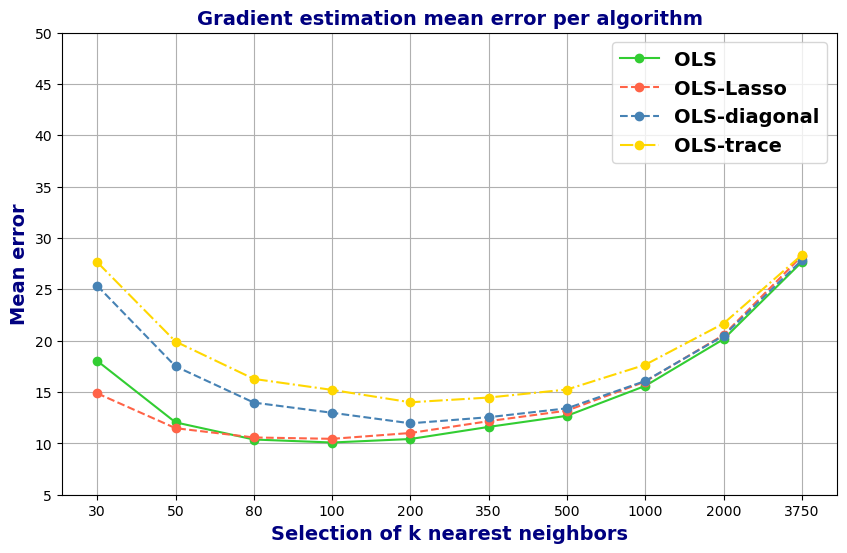

In [64]:
k_values1, mean_values1 = list(mean_losses_ols_5000_12.keys()), list(mean_losses_ols_5000_12.values())
k_values2, mean_values2 = list(mean_losses_ols_l_5000_12.keys()), list(mean_losses_ols_l_5000_12.values())
k_values3, mean_values3 = list(mean_losses_ols_d_5000_12.keys()), list(mean_losses_ols_d_5000_12.values())
k_values4, mean_values4 = list(mean_losses_ols_t_5000_12.keys()), list(mean_losses_ols_t_5000_12.values())

# Generate evenly spaced indices for the x-axis
x_indices_ = range(len(k_values1))
# Plot the mean values for all three sets
plt.figure(figsize=(10, 6))
plt.plot(x_indices_, mean_values1, marker='o', linestyle='-', color='#32CD32' , label='OLS')
plt.plot(x_indices_, mean_values2, marker='o', linestyle='--', color='#FF6347', label='OLS-Lasso')
plt.plot(x_indices_, mean_values3, marker='o', linestyle='--', color='#4682B4', label='OLS-diagonal')
plt.plot(x_indices_, mean_values4, marker='o', linestyle='-.', color='#FFD700', label='OLS-trace')


# Adding labels and title
plt.xlabel('Selection of k nearest neighbors',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Mean error',fontsize=14, fontweight='bold', color='navy')
plt.title('Gradient estimation mean error per algorithm',fontsize=14, fontweight='bold', color='navy')
plt.xticks(sorted(x_indices_),labels=sorted(k_values1))
plt.ylim(5,50)
plt.legend(prop={'weight': 'bold', 'size': 14, 'family': 'sans-serif'})
plt.grid(True)
#plt.savefig('lineplot_gradient2_n=5000_12.pdf', bbox_inches='tight')
plt.show()

### Heatmap 

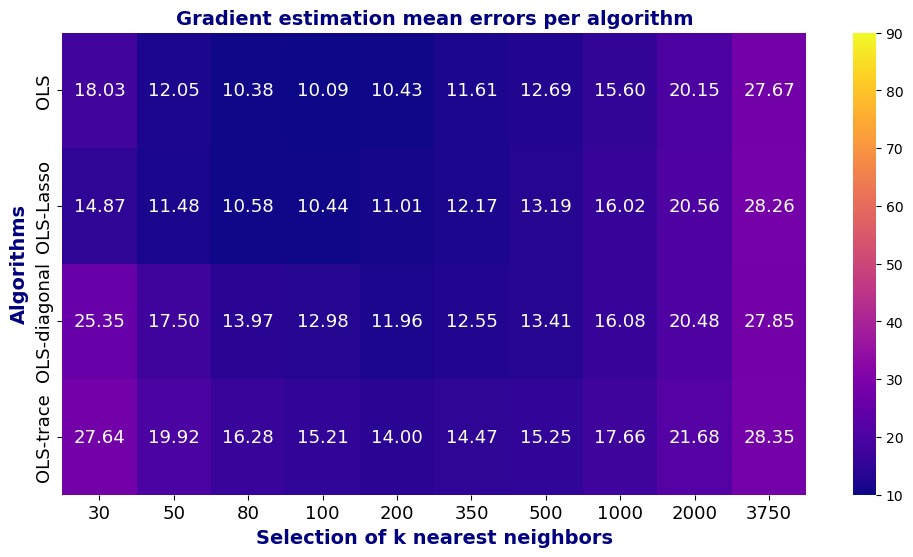

In [61]:
k_values1, mean_values1 = list(mean_losses_ols_5000_12.keys()), list(mean_losses_ols_5000_12.values())
k_values2, mean_values2 = list(mean_losses_ols_l_5000_12.keys()), list(mean_losses_ols_l_5000_12.values())
k_values3, mean_values3 = list(mean_losses_ols_d_5000_12.keys()), list(mean_losses_ols_d_5000_12.values())
k_values4, mean_values4 = list(mean_losses_ols_t_5000_12.keys()), list(mean_losses_ols_t_5000_12.values())

heatmap_data = []
for k in mean_losses_ols_5000_12.keys():
    row = [mean_losses_ols_5000_12[k], mean_losses_ols_l_5000_12[k], mean_losses_ols_d_5000_12[k], mean_losses_ols_t_5000_12[k]]
    heatmap_data.append(row)

# Convert the list to a NumPy array
heatmap_data = np.array(heatmap_data).T

# Create a heatmap
plt.subplots(figsize=(12,6)) 
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='plasma',vmin=10,vmax=90, yticklabels=['OLS','OLS-Lasso',
                                                                                     'OLS-diagonal', 'OLS-trace']
                                                                              , xticklabels=sorted(mean_losses_ols_5000_12.keys()),
           annot_kws={"size": 13})
plt.xlabel('Selection of k nearest neighbors',fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Algorithms',fontsize=14, fontweight='bold', color='navy')
plt.title('Gradient estimation mean errors per algorithm',fontsize=14, fontweight='bold', color='navy')
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
#plt.savefig('heatmap_gradient2_n=5000_12.pdf', bbox_inches='tight')
plt.show()